In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, chi2
from scipy.stats import binomtest, binom
from scipy.optimize import minimize
from scipy.optimize import minimize
from scipy.stats import genpareto


# Importation des données

In [2]:
# import yfinance as yf
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd

# # Télécharger les données
# df = yf.download("^GDAXI", start="2000-01-01", end="2026-01-01")

# # Calculer les rendements logarithmiques
# df['returns'] = np.log(df['Close'] / df['Close'].shift(1))


In [3]:
df = pd.read_csv('../data/dax.csv')
df['Date']=pd.to_datetime(df['Date'],yearfirst=True)
df = df.set_index(df['Date'])
df.head()

,Date,Close,High,Low,Open,Volume,returns
Date,,,,,,,
2000-01-03,2000-01-03,6750.759766,7159.330078,6720.870117,6961.720215,43072500,NaN
2000-01-04,2000-01-04,6586.950195,6755.359863,6510.459961,6747.240234,46678400,-0.024565
2000-01-05,2000-01-05,6502.069824,6585.850098,6388.910156,6585.850098,52682800,-0.012970
2000-01-06,2000-01-06,6474.919922,6539.310059,6402.629883,6501.450195,41180600,-0.004184
2000-01-07,2000-01-07,6780.959961,6791.529785,6470.140137,6489.939941,56058900,0.046182


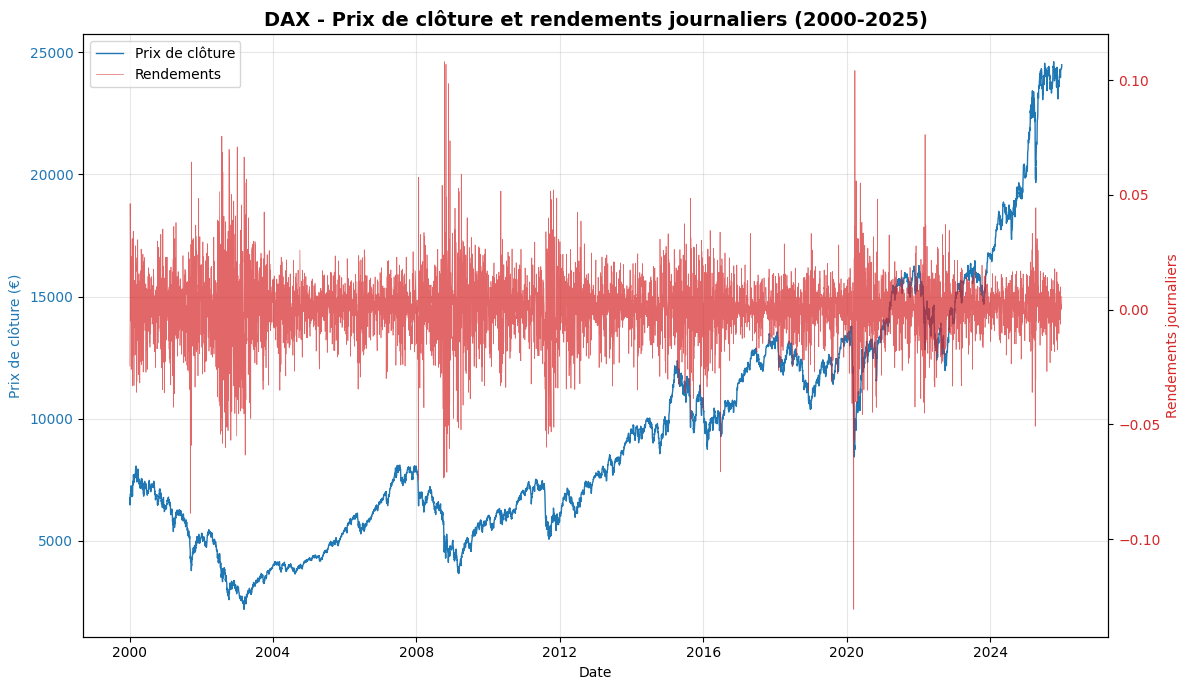

In [4]:
# Créer la figure avec deux axes Y
fig, ax1 = plt.subplots(figsize=(12, 7))

# Premier axe Y (gauche) - Prix de clôture
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Prix de clôture (€)', color=color)
ax1.plot(df['Date'], df['Close'], color=color, linewidth=1, label='Prix de clôture')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Deuxième axe Y (droite) - Rendements
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Rendements journaliers', color=color)
ax2.plot(df['Date'], df['returns'], color=color, alpha=0.7, linewidth=0.5, label='Rendements')
ax2.tick_params(axis='y', labelcolor=color)

# Titre et légende
plt.title('DAX - Prix de clôture et rendements journaliers (2000-2025)', fontsize=14, fontweight='bold')

# Créer une légende combinée
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

# Etude volatilité

Les périodes de forte volatilité sont détectées automatiquement en identifiant les instants où une mesure locale de dispersion dépasse un seuil extrême défini par un quantile élevé de sa distribution empirique. Cette approche permet de capturer les régimes de marché caractérisés par une accumulation d’événements extrêmes.

Les périodes de forte volatilité détectées correspondent à des phases de stress de marché, caractérisées par une augmentation marquée de l’amplitude des rendements. Le découpage retenu permet de calibrer les modèles de risque sur une période stable, puis d’évaluer leurs performances lors d’une phase de forte instabilité, ce qui correspond à un cadre réaliste de gestion du risque.

In [5]:
def plot_volatility_periods(returns, periods, title=None):
    """
    returns : pd.Series (index = dates)
    periods : liste de tuples (start_date, end_date)
    """

    plt.figure(figsize=(12, 5))
    plt.plot(returns.index, returns.values, label="Rendements", linewidth=1)

    # Zones de forte volatilité
    for i, (start, end) in enumerate(periods):
        plt.axvspan(start, end, alpha=0.3, color = 'red',
                    label="Forte volatilité" if i == 0 else None)

    plt.axhline(0, linestyle="--", linewidth=0.8)
    plt.xlabel("Date")
    plt.ylabel("Rendement")
    plt.title(title if title else "Périodes de forte volatilité")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [6]:
returns = df['returns']
returns.index = df['Date']

## Détection des périodes de forte volatilité sur des fenetres glissantes

La volatilité des rendements étant variable dans le temps, une mesure locale est estimée à l’aide d’une volatilité calculée sur une fenêtre glissante. À chaque date $t$, la volatilité roulante $\sigma_t$ correspond à l’écart-type des rendements observés sur les $h$ périodes précédentes.

Afin d’identifier les régimes de marché instables, un seuil de forte volatilité est défini comme un quantile élevé de la distribution empirique de $\sigma_t$. Une date est considérée comme appartenant à une phase de forte volatilité lorsque $\sigma_t$ dépasse ce seuil.

Les périodes de forte volatilité sont ensuite définies comme des intervalles de temps continus pour lesquels cette condition est vérifiée.


In [7]:
def detect_high_volatility_periods(
    returns,
    window=20,
    quantile=0.95
):
    """
    returns : pd.Series (index = dates)
    window  : taille de la fenêtre roulante
    quantile: seuil de forte volatilité
    """

    # 1️⃣ Volatilité roulante (RMS)
    rolling_vol = np.sqrt(
        returns.rolling(window).mean()**2 +
        returns.rolling(window).var()
    )

    # Version encore plus simple et classique :
    # rolling_vol = returns.rolling(window).std()

    # 2️⃣ Seuil extrême
    threshold = rolling_vol.quantile(quantile)

    # 3️⃣ Indicateur forte volatilité
    high_vol = rolling_vol > threshold

    # 4️⃣ Extraction des périodes continues
    periods = []
    in_period = False

    for date, is_high in high_vol.items():
        if is_high and not in_period:
            start = date
            in_period = True
        elif not is_high and in_period:
            end = date
            periods.append((start, end))
            in_period = False

    # Cas où la série finit en période de forte vol
    if in_period:
        periods.append((start, high_vol.index[-1]))

    return periods


In [8]:
periods1 = detect_high_volatility_periods(returns,window=80)

for i, (start, end) in enumerate(periods1, 1):
    print(f"Période de forte volatilité n°{i} : du {start.date()} au {end.date()}")


Période de forte volatilité n°1 : du 2002-08-08 au 2003-02-13
Période de forte volatilité n°2 : du 2003-02-14 au 2003-02-17
Période de forte volatilité n°3 : du 2003-03-21 au 2003-04-28
Période de forte volatilité n°4 : du 2008-10-28 au 2009-03-18
Période de forte volatilité n°5 : du 2011-11-11 au 2011-11-25
Période de forte volatilité n°6 : du 2011-11-28 au 2011-11-29
Période de forte volatilité n°7 : du 2011-11-30 au 2011-12-01
Période de forte volatilité n°8 : du 2020-04-06 au 2020-07-08


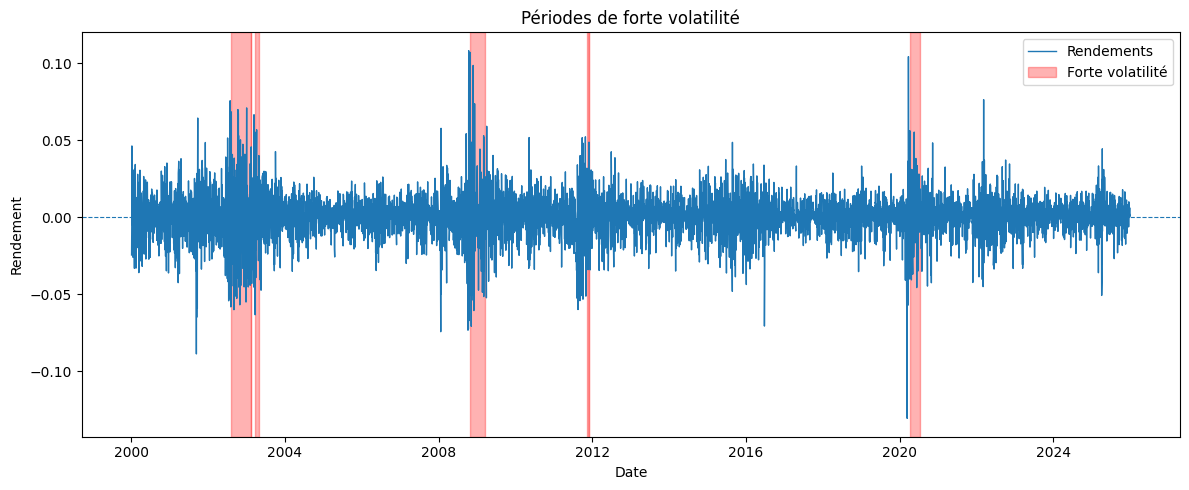

In [9]:
plot_volatility_periods(returns, periods1)

## Détection des périodes de forte volatilité – Approche POT

La forte volatilité se manifeste par une fréquence élevée de rendements de grande amplitude. On considère donc la série des valeurs absolues des rendements $X_t = |r_t|$ et on applique une approche de type Peaks Over Threshold (POT).

Un seuil élevé $u$ est défini comme un quantile de la distribution empirique de $X_t$. Les observations telles que $X_t > u$ sont interprétées comme des événements extrêmes.

Les périodes de forte volatilité sont identifiées en comptabilisant, sur une fenêtre glissante, le nombre d’excès au-dessus du seuil. Un intervalle de temps est considéré comme un régime de forte volatilité lorsque cette fréquence dépasse un niveau donné.


In [10]:
def detect_extreme_volatility_periods(
    returns,
    window=20,
    quantile=0.95,
    min_exceedances=4
):
    """
    returns : pd.Series (index = dates)
    window  : fenêtre glissante
    quantile: seuil POT
    min_exceedances : nombre minimal d'excès dans la fenêtre
    """

    # 1️⃣ Valeurs absolues
    abs_returns = returns.abs()

    # 2️⃣ Seuil POT
    threshold = abs_returns.quantile(quantile)

    # 3️⃣ Indicateur d'excès
    exceedances = abs_returns > threshold

    # 4️⃣ Comptage glissant des excès
    rolling_exceedances = exceedances.rolling(window).sum()

    # 5️⃣ Régime de forte volatilité
    high_vol = rolling_exceedances >= min_exceedances

    # 6️⃣ Extraction des périodes continues
    periods = []
    in_period = False

    for date, is_high in high_vol.items():
        if is_high and not in_period:
            start = date
            in_period = True
        elif not is_high and in_period:
            end = date
            periods.append((start, end))
            in_period = False

    if in_period:
        periods.append((start, high_vol.index[-1]))

    return periods


In [11]:
periods2 = detect_extreme_volatility_periods(returns,window=80)

for i, (start, end) in enumerate(periods2, 1):
    print(f"Période de forte volatilité n°{i} : du {start.date()} au {end.date()}")


Période de forte volatilité n°1 : du 2000-04-25 au 2000-07-06
Période de forte volatilité n°2 : du 2000-12-05 au 2001-07-20
Période de forte volatilité n°3 : du 2001-09-11 au 2002-04-05
Période de forte volatilité n°4 : du 2002-06-17 au 2003-08-28
Période de forte volatilité n°5 : du 2003-09-24 au 2003-10-22
Période de forte volatilité n°6 : du 2003-11-17 au 2004-01-19
Période de forte volatilité n°7 : du 2008-02-05 au 2008-06-06
Période de forte volatilité n°8 : du 2008-10-06 au 2009-10-12
Période de forte volatilité n°9 : du 2010-05-27 au 2010-08-30
Période de forte volatilité n°10 : du 2011-08-08 au 2012-04-03
Période de forte volatilité n°11 : du 2012-04-04 au 2012-04-13
Période de forte volatilité n°12 : du 2012-04-23 au 2012-04-25
Période de forte volatilité n°13 : du 2012-06-01 au 2012-10-22
Période de forte volatilité n°14 : du 2015-01-08 au 2015-02-11
Période de forte volatilité n°15 : du 2015-07-10 au 2016-01-18
Période de forte volatilité n°16 : du 2016-02-08 au 2016-04-27
P

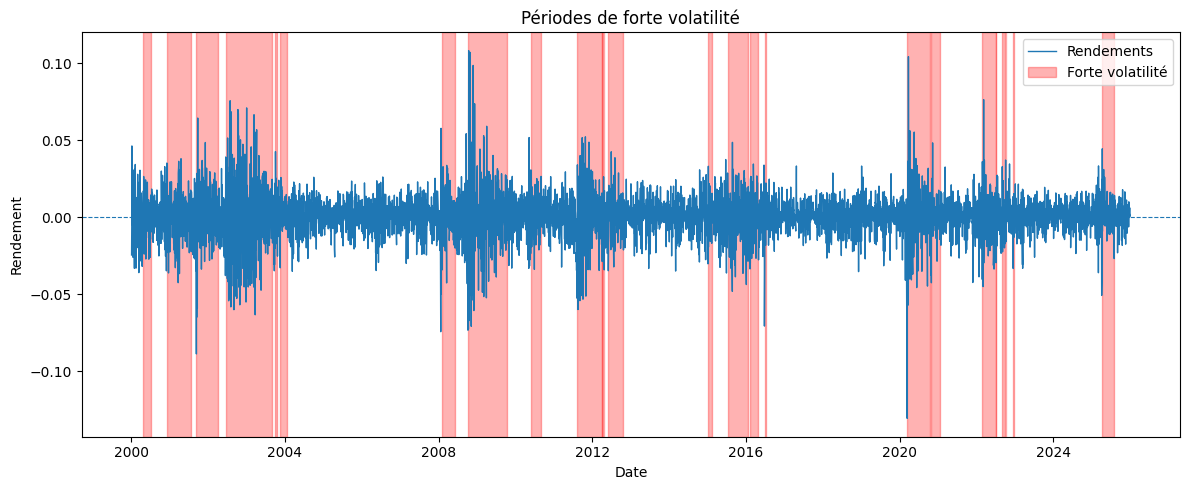

In [12]:
plot_volatility_periods(returns, periods2)

## Détection des périodes de forte volatilité – Approche GARCH

La volatilité des rendements est modélisée à l’aide d’un modèle GARCH(1,1), permettant de capturer la dépendance temporelle et la persistance de la volatilité.

À partir de la volatilité conditionnelle estimée, un seuil de forte volatilité est défini comme un quantile élevé de sa distribution empirique. Les périodes de forte volatilité correspondent alors aux intervalles de temps durant lesquels la volatilité conditionnelle dépasse ce seuil.


In [13]:
from arch import arch_model

def detect_garch_volatility_periods(
    returns,
    quantile=0.95
):
    """
    returns : pd.Series (index = dates)
    """
    returns = returns.copy()
    returns = returns.dropna()

    # 1️⃣ Estimation GARCH(1,1)
    model = arch_model(returns * 100, vol="Garch", p=1, q=1, mean="Zero")
    res = model.fit(disp="off")

    # 2️⃣ Volatilité conditionnelle
    cond_vol = res.conditional_volatility
    cond_vol.index = returns.index

    # 3️⃣ Seuil extrême
    threshold = cond_vol.quantile(quantile)

    # 4️⃣ Régimes de forte volatilité
    high_vol = cond_vol > threshold

    # 5️⃣ Extraction des périodes continues
    periods = []
    in_period = False

    for date, is_high in high_vol.items():
        if is_high and not in_period:
            start = date
            in_period = True
        elif not is_high and in_period:
            end = date
            periods.append((start, end))
            in_period = False

    if in_period:
        periods.append((start, high_vol.index[-1]))

    return periods, cond_vol


In [14]:
periods3, cond_vol = detect_garch_volatility_periods(returns,quantile=0.95)

for i, (start, end) in enumerate(periods3, 1):
    print(f"Période de forte volatilité n°{i} : du {start.date()} au {end.date()}")


Période de forte volatilité n°1 : du 2001-09-12 au 2001-10-10
Période de forte volatilité n°2 : du 2001-10-11 au 2001-10-12
Période de forte volatilité n°3 : du 2002-07-08 au 2002-07-10
Période de forte volatilité n°4 : du 2002-07-11 au 2002-07-15
Période de forte volatilité n°5 : du 2002-07-16 au 2002-11-20
Période de forte volatilité n°6 : du 2002-11-28 au 2002-11-29
Période de forte volatilité n°7 : du 2002-12-11 au 2002-12-12
Période de forte volatilité n°8 : du 2002-12-17 au 2002-12-18
Période de forte volatilité n°9 : du 2002-12-19 au 2002-12-27
Période de forte volatilité n°10 : du 2002-12-30 au 2003-01-15
Période de forte volatilité n°11 : du 2003-01-20 au 2003-01-21
Période de forte volatilité n°12 : du 2003-02-20 au 2003-02-21
Période de forte volatilité n°13 : du 2003-02-26 au 2003-02-27
Période de forte volatilité n°14 : du 2003-03-14 au 2003-04-17
Période de forte volatilité n°15 : du 2008-01-22 au 2008-01-23
Période de forte volatilité n°16 : du 2008-01-24 au 2008-02-01
P

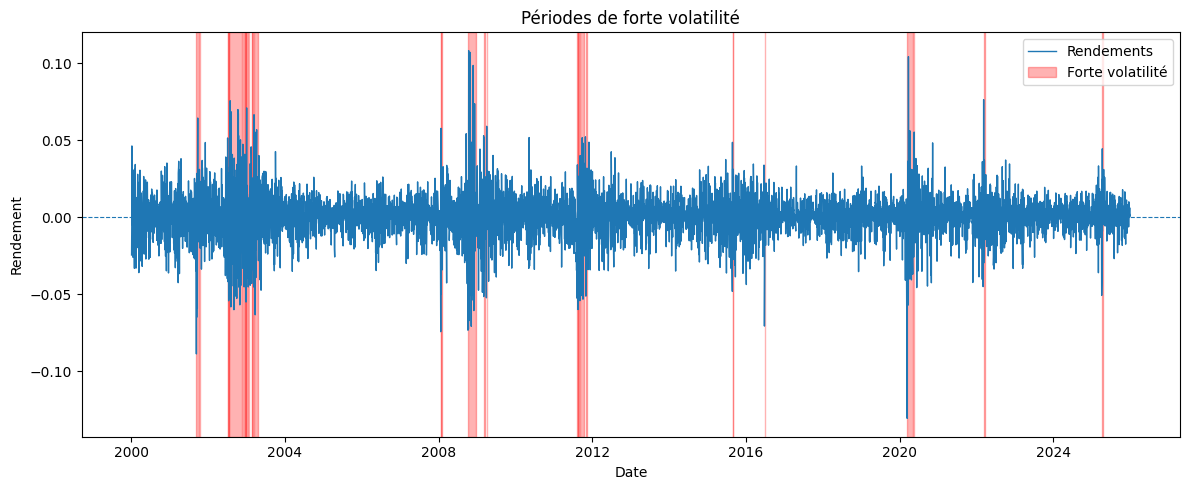

In [15]:
plot_volatility_periods(returns, periods3)

# train test split

In [16]:
bornes = ['2016-07-06','2020-03-06','2020-10-14']

train = df[(df['Date'] >= bornes[0]) & 
                     (df['Date'] < bornes[1])]
test = df[(df['Date'] >= bornes[1]) & 
                    (df['Date'] <= bornes[2])]

print(f"Train shape: {train.shape[0]}, Période: {train.index[0]} à {train.index[-1]}")
print(f"Test shape: {test.shape[0]}, Période: {test.index[0]} à {test.index[-1]}")

Train shape: 926, Période: 2016-07-06 00:00:00 à 2020-03-05 00:00:00
Test shape: 155, Période: 2020-03-06 00:00:00 à 2020-10-14 00:00:00


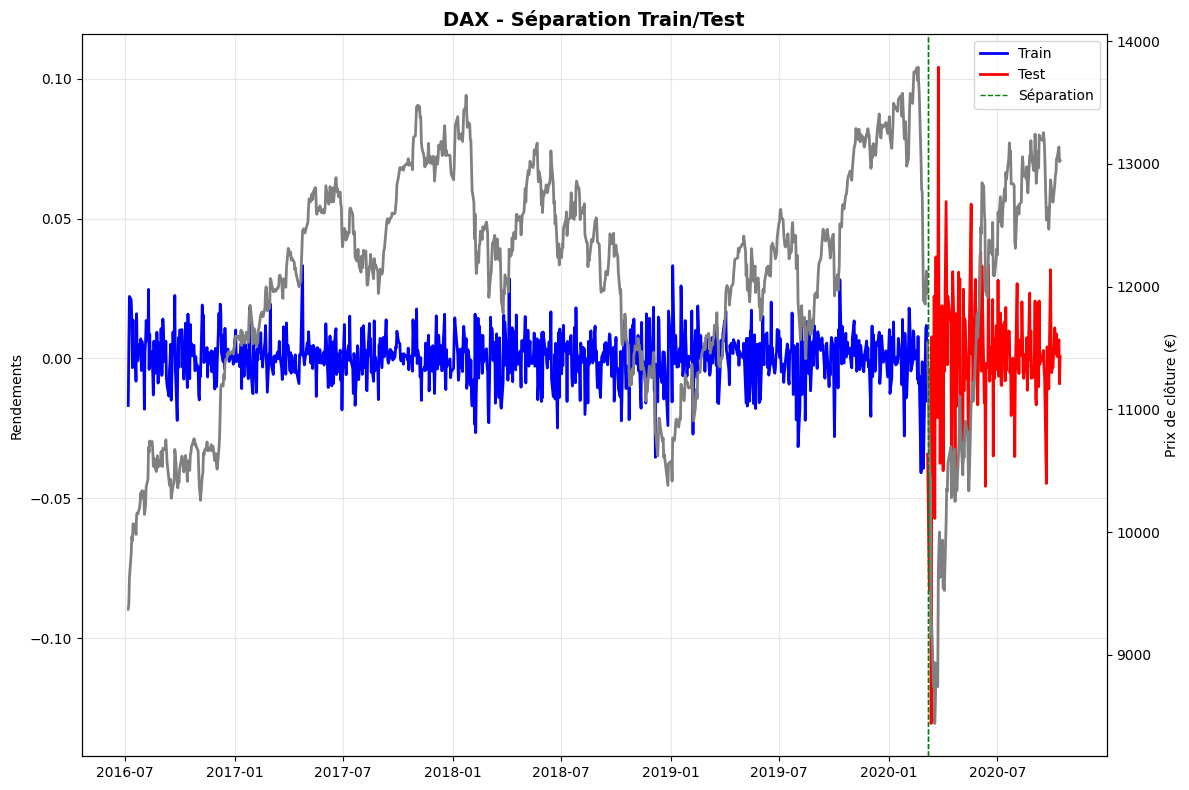

In [17]:
# Créer un graphique montrant les périodes train/test
fig, ax2 = plt.subplots(figsize=(12, 8))

# Graphique complet



ax2.plot(train.index, train['returns'], color='blue', linewidth=2, label='Train')
ax2.plot(test.index, test['returns'], color='red', linewidth=2, label='Test')
ax2.axvline(x=pd.Timestamp(bornes[1]), color='green', linestyle='--', 
            linewidth=1, label='Séparation')
ax2.set_ylabel('Rendements')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax1 = ax2.twinx()
ax1.plot(train.index, train['Close'], color='gray', linewidth=2)
ax1.plot(test.index, test['Close'], color='gray', linewidth=2)
ax1.axvline(x=pd.Timestamp(bornes[1]), color='green', linestyle='--', 
            linewidth=1, label='Séparation')
ax1.set_title('DAX - Séparation Train/Test', fontsize=14, fontweight='bold')
ax1.set_ylabel('Prix de clôture (€)')


plt.tight_layout()
plt.show()

In [18]:
# Fonction pour des statistiques complètes
def detailed_stats(dataframe, name):
    stats_dict = {}
    
    for column in ['Close', 'returns']:
        if column in dataframe.columns:
            col_data = dataframe[column].dropna()
            stats_dict[f'{column}_mean'] = col_data.mean()
            stats_dict[f'{column}_std'] = col_data.std()
            stats_dict[f'{column}_min'] = col_data.min()
            stats_dict[f'{column}_max'] = col_data.max()
            stats_dict[f'{column}_median'] = col_data.median()
            stats_dict[f'{column}_skew'] = col_data.skew()
            stats_dict[f'{column}_kurtosis'] = col_data.kurtosis()
            stats_dict[f'{column}_q25'] = col_data.quantile(0.25)
            stats_dict[f'{column}_q75'] = col_data.quantile(0.75)
            stats_dict[f'{column}_count'] = len(col_data)
    
    return pd.DataFrame(stats_dict, index=[name])

# Calculer les statistiques
train_stats = detailed_stats(train[['returns']], 'Train')
test_stats = detailed_stats(test[['returns']], 'Test')

# Combiner et afficher
comparison_stats = pd.concat([train_stats, test_stats])
print("\nCOMPARAISON DES STATISTIQUES TRAIN/TEST :")
print(comparison_stats.round(4))


COMPARAISON DES STATISTIQUES TRAIN/TEST :
       returns_mean  returns_std  returns_min  returns_max  returns_median  \
Train        0.0002       0.0089      -0.0409       0.0332          0.0007   
Test         0.0006       0.0243      -0.1305       0.1041          0.0007   

       returns_skew  returns_kurtosis  returns_q25  returns_q75  returns_count  
Train       -0.4131            1.8855      -0.0042       0.0053            926  
Test        -0.8892            7.4385      -0.0071       0.0124            155  


C:\Users\UltraBook 3.1\AppData\Local\Temp\ipykernel_31396\2805866505.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax3.boxplot(data_to_plot, labels=['Train', 'Test'])


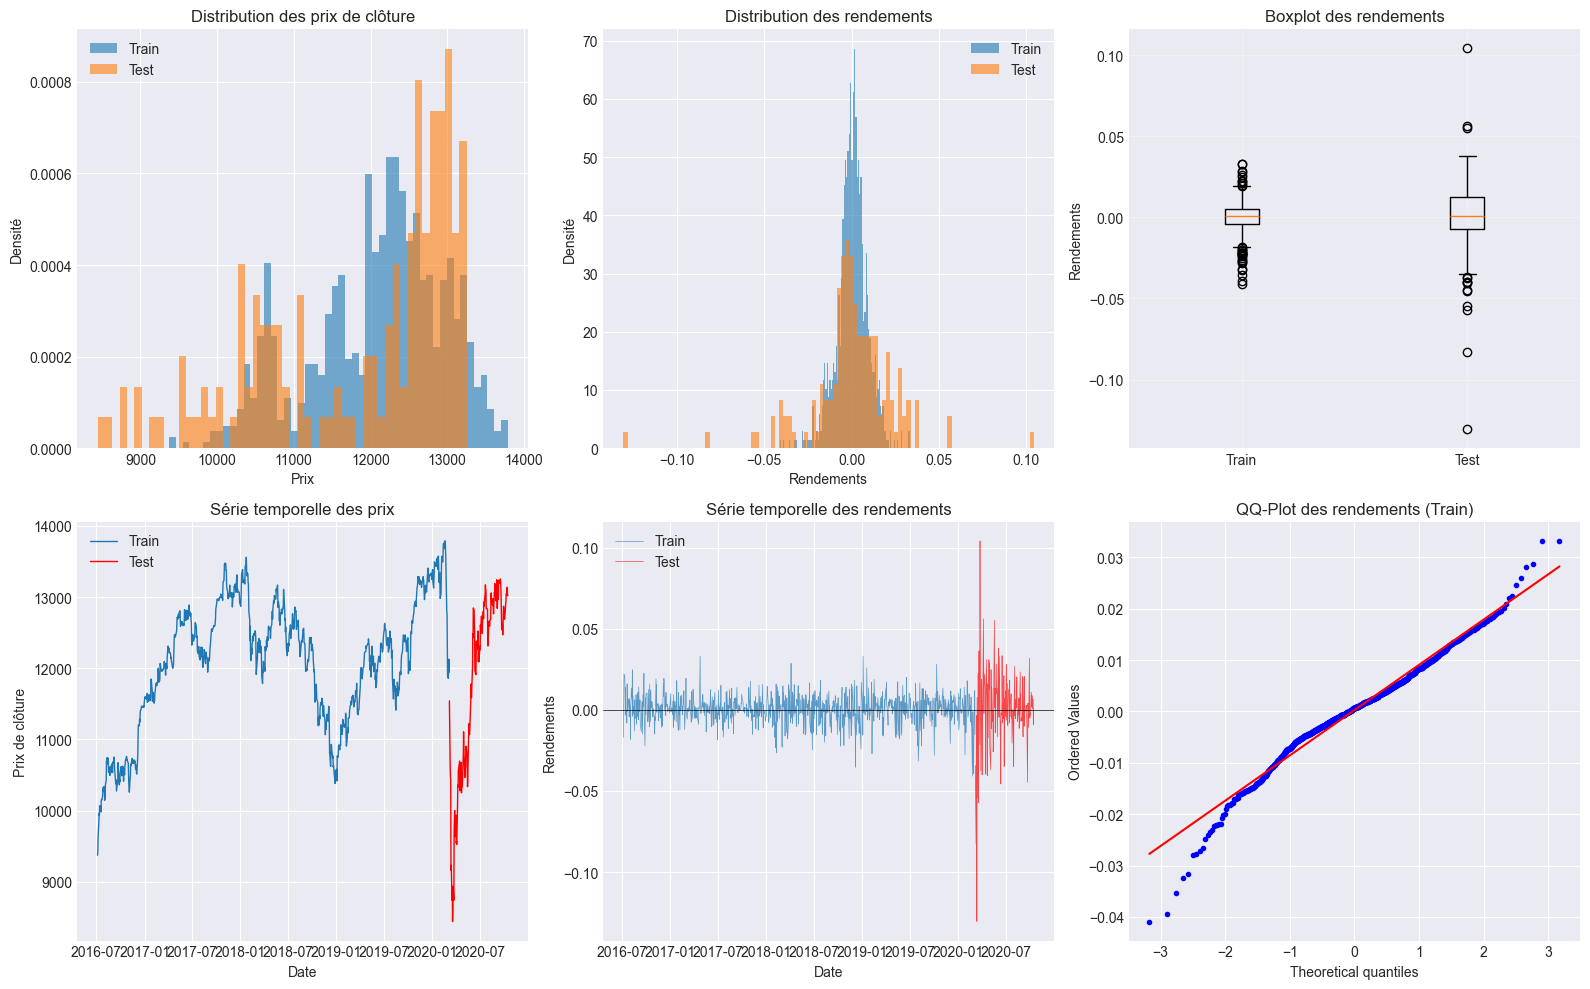

In [19]:
# Configuration du style
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(16, 10))

# 1. Distribution des prix de clôture
ax1 = plt.subplot(2, 3, 1)
ax1.hist(train['Close'].dropna(), bins=50, alpha=0.6, label='Train', density=True)
ax1.hist(test['Close'].dropna(), bins=50, alpha=0.6, label='Test', density=True)
ax1.set_title('Distribution des prix de clôture')
ax1.set_xlabel('Prix')
ax1.set_ylabel('Densité')
ax1.legend()

# 2. Distribution des rendements
ax2 = plt.subplot(2, 3, 2)
ax2.hist(train['returns'].dropna(), bins=100, alpha=0.6, label='Train', density=True)
ax2.hist(test['returns'].dropna(), bins=100, alpha=0.6, label='Test', density=True)
ax2.set_title('Distribution des rendements')
ax2.set_xlabel('Rendements')
ax2.set_ylabel('Densité')
ax2.legend()

# 3. Boxplot des rendements
ax3 = plt.subplot(2, 3, 3)
data_to_plot = [train['returns'].dropna(), test['returns'].dropna()]
ax3.boxplot(data_to_plot, labels=['Train', 'Test'])
ax3.set_title('Boxplot des rendements')
ax3.set_ylabel('Rendements')
ax3.grid(True, alpha=0.3)

# 4. Série temporelle des prix
ax4 = plt.subplot(2, 3, 4)
ax4.plot(train.index, train['Close'], label='Train', linewidth=1)
ax4.plot(test.index, test['Close'], label='Test', linewidth=1, color='red')
ax4.set_title('Série temporelle des prix')
ax4.set_xlabel('Date')
ax4.set_ylabel('Prix de clôture')
ax4.legend()

# 5. Série temporelle des rendements
ax5 = plt.subplot(2, 3, 5)
ax5.plot(train.index, train['returns'], label='Train', linewidth=0.5, alpha=0.7)
ax5.plot(test.index, test['returns'], label='Test', linewidth=0.5, alpha=0.7, color='red')
ax5.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax5.set_title('Série temporelle des rendements')
ax5.set_xlabel('Date')
ax5.set_ylabel('Rendements')
ax5.legend()

# 6. QQ-Plot pour la normalité des rendements
ax6 = plt.subplot(2, 3, 6)
stats.probplot(train['returns'].dropna(), dist="norm", plot=ax6)
ax6.set_title('QQ-Plot des rendements (Train)')
ax6.get_lines()[0].set_markersize(3)

plt.tight_layout()
plt.show()

In [20]:
# Calcul des métriques de risque
def calculate_risk_metrics(returns_series, name, risk_free_rate=0.02/252):
    """Calcule les métriques de risque"""
    returns = returns_series.dropna()
    
    metrics = {
        'Période': name,
        'Nb_observations': len(returns),
        'Rendement_moyen_journalier': returns.mean(),
        'Rendement_annualisé': returns.mean() * 252,
        'Volatilité_journalière': returns.std(),
        'Volatilité_annualisée': returns.std() * np.sqrt(252),
        'Ratio_de_Sharpe': (returns.mean() - risk_free_rate) / returns.std() * np.sqrt(252),
        'Skewness': returns.skew(),
        'Kurtosis': returns.kurtosis(),
        'VaR_95%': returns.quantile(0.05),
        'ES_95%': returns[returns <= returns.quantile(0.05)].mean(),
        'Maximum_Drawdown': (returns.cumsum().expanding().max() - returns.cumsum()).max(),
        'Ratio_Sortino': returns.mean() / returns[returns < 0].std()
    }
    
    return metrics

# Calculer pour train et test
train_metrics = calculate_risk_metrics(train['returns'], 'Train')
test_metrics = calculate_risk_metrics(test['returns'], 'Test')

# Créer un DataFrame comparatif
risk_comparison = pd.DataFrame([train_metrics, test_metrics]).set_index('Période')
print("\n" + "=" * 60)
print("COMPARAISON DES MÉTRIQUES DE RISQUE")
print("=" * 60)
print(risk_comparison.round(4))


COMPARAISON DES MÉTRIQUES DE RISQUE
         Nb_observations  Rendement_moyen_journalier  Rendement_annualisé  \
Période                                                                     
Train                926                      0.0002               0.0614   
Test                 155                      0.0006               0.1411   

         Volatilité_journalière  Volatilité_annualisée  Ratio_de_Sharpe  \
Période                                                                   
Train                    0.0089                 0.1413           0.2928   
Test                     0.0243                 0.3856           0.3142   

         Skewness  Kurtosis  VaR_95%  ES_95%  Maximum_Drawdown  Ratio_Sortino  
Période                                                                        
Train     -0.4131    1.8855  -0.0153 -0.0210            0.2671         0.0369  
Test      -0.8892    7.4385  -0.0399 -0.0621            0.3128         0.0267  


In [21]:
from scipy.stats import ttest_ind, ks_2samp, levene

print("\n" + "=" * 60)
print("TESTS STATISTIQUES COMPARATIFS")
print("=" * 60)

# T-test pour différence des moyennes
t_stat, p_value = ttest_ind(train['returns'].dropna(), test['returns'].dropna(), 
                            equal_var=False)
print(f"Test t pour égalité des moyennes:")
print(f"  t-statistique = {t_stat:.4f}, p-value = {p_value:.4f}")
print(f"  Conclusion: {'Différence significative' if p_value < 0.05 else 'Pas de différence significative'}")

# Test de Kolmogorov-Smirnov
ks_stat, ks_p = ks_2samp(train['returns'].dropna(), test['returns'].dropna())
print(f"\nTest de Kolmogorov-Smirnov:")
print(f"  KS-statistique = {ks_stat:.4f}, p-value = {ks_p:.4f}")
print(f"  Conclusion: {'Distributions différentes' if ks_p < 0.05 else 'Distributions similaires'}")

# Test de Levene pour égalité des variances
levene_stat, levene_p = levene(train['returns'].dropna(), test['returns'].dropna())
print(f"\nTest de Levene pour égalité des variances:")
print(f"  Statistique = {levene_stat:.4f}, p-value = {levene_p:.4f}")
print(f"  Conclusion: {'Variances différentes' if levene_p < 0.05 else 'Variances égales'}")


TESTS STATISTIQUES COMPARATIFS
Test t pour égalité des moyennes:
  t-statistique = -0.1604, p-value = 0.8727
  Conclusion: Pas de différence significative

Test de Kolmogorov-Smirnov:
  KS-statistique = 0.1973, p-value = 0.0001
  Conclusion: Distributions différentes

Test de Levene pour égalité des variances:
  Statistique = 141.0488, p-value = 0.0000
  Conclusion: Variances différentes


# 1.	VaR non paramétrique


## 1.1 VaR historique
### a.	Ecrire une fonction calculant la VaR historique d’un ensemble de log-rendements VaR_Hist(x, alpha


In [22]:
alpha = 0.99

In [23]:
def VaR_Hist(x, alpha=0.95):
    """
    Calcule la Value at Risk (VaR) historique d'une série de rendements.
    
    Paramètres:
    -----------
    x : array-like ou Series
        Série des rendements logaritmiques
    alpha : float
        Niveau de confiance (ex: 0.95 pour 95%, 0.99 pour 99%)
    
    Retourne:
    ---------
    float : VaR historique au niveau alpha
    """
    # S'assurer que x est un array numpy
    x = np.array(x)
    
    # Retirer les valeurs NaN
    x_clean = x[~np.isnan(x)]
    
    return np.percentile(x_clean, (1 - alpha) * 100)

### b.	Calculer la VaR historique sur base d’apprentissage pour alpha = 99%.

In [24]:
var_hist = VaR_Hist(train['returns'],alpha=alpha)
print('VaR historique à 99 % :', round(var_hist,5))

VaR historique à 99 % : -0.02468


### c.	Ecrire une fonction calculant la VaR historique bootstrap 
d’un ensemble de log-rendements et donnant un IC de niveau alpha_IC de cette VaR
 VaR_Hist_Bootstrap(x, alpha, B, alpha_IC)


In [25]:
def VaR_Hist_Bootstrap(x, alpha=0.95, B=1000, alpha_IC=0.95,seed = 42):
    """
    Calcule la VaR historique par bootstrap avec intervalle de confiance.
    
    Paramètres:
    -----------
    x : array-like
        Série des rendements logaritmiques
    alpha : float
        Niveau de confiance de la VaR (ex: 0.95 pour 95%)
    B : int
        Nombre de réplications bootstrap
    alpha_IC : float
        Niveau de confiance de l'intervalle (ex: 0.95 pour 95%)
    seed : int
        graine aléatoire pour la reproductivité
    """
    # Conversion et nettoyage
    x = np.asarray(x).flatten()
    x_clean = x[~np.isnan(x)]
    n = len(x_clean)
    
    # Fixer la seed
    np.random.seed(seed)
    
    
    # Créer une matrice de taille (B, n) avec des tirages aléatoires d'indices
    indices = np.random.randint(0, n, size=(B, n))

    # Créer une matrice (B, n) d'échantillons bootstrap
    bootstrap_samples = x_clean[indices]
    
    percentiles = (1 - alpha) * 100
    bootstrap_vars = np.percentile(bootstrap_samples, percentiles, axis=1)
    
    # Statistiques
    var_bootstrap = np.mean(bootstrap_vars)
    std_error = np.std(bootstrap_vars)
    
    # Intervalle de confiance
    lower_percentile = (1 - alpha_IC) / 2 * 100
    upper_percentile = (1 - (1 - alpha_IC) / 2) * 100
    
    ic_inf = np.percentile(bootstrap_vars, lower_percentile)
    ic_sup = np.percentile(bootstrap_vars, upper_percentile)
    
    return {
        'VaR_bootstrap': var_bootstrap,
        'IC_inf': ic_inf,
        'IC_sup': ic_sup,
        'std_error': std_error,
    }

### d.	Calculer la VaR historique bootstrap et l’IC associé à 90% sur base d’apprentissage pour alpha = 99%.

In [26]:
dict_boost = VaR_Hist_Bootstrap(train['returns'],alpha=alpha,alpha_IC=0.90)
print(f"\nEstimation bootstrap:")
print(f"  VaR bootstrap:      {dict_boost['VaR_bootstrap']:.6f}")
print(f"  Erreur standard:    {dict_boost['std_error']:.6f}")
print(f"  Borne inférieure:  {dict_boost['IC_inf']:.6f}")
print(f"  Borne supérieure:  {dict_boost['IC_sup']:.6f}")


Estimation bootstrap:
  VaR bootstrap:      -0.025091
  Erreur standard:    0.002317
  Borne inférieure:  -0.027996
  Borne supérieure:  -0.022156


### e.	Calculer le nombre d’exceptions sur base de test associées à la VaR historique calculée en 1.b.

In [27]:
def count_exceptions(returns, var_value, alpha=0.95,alternative='greater'):
    """
    Compte les exceptions (violations) dans une série de rendements.
    
    Paramètres:
    -----------
    returns : array-like
        Série des rendements
    var_value : float
        Valeur de la VaR (négative pour les pertes)
    alpha : float
        Niveau de confiance de la VaR
    
    Retourne:
    ---------
    dict : Statistiques des exceptions
    """
    returns_array = np.asarray(returns).flatten()
    returns_clean = returns_array[~np.isnan(returns_array)]
    
    # Les exceptions sont les rendements inférieurs à la VaR
    # (VaR est généralement négative, donc plus petite = pire)
    exceptions = returns_clean < var_value
    n_exceptions = np.sum(exceptions)
    n_obs = len(returns_clean)
    exception_rate = n_exceptions / n_obs
    
    # Statistiques attendues
    expected_exceptions = (1 - alpha) * n_obs
    bin = binomtest(
        k=n_exceptions,
        n= n_obs,
        p= 1-alpha,
        alternative=alternative
    )
    
    return {
        'VaR_value': var_value,
        'alpha': alpha,
        'n_observations': n_obs,
        'n_exceptions': int(n_exceptions),
        'exception_rate': exception_rate,
        'expected_exceptions': expected_exceptions,
        'binom_test': bin
        
    }

In [28]:
def plot_exceptions(returns_test,alpha, var,name = '',alternative='greater'):
    """
    Visualise les rendements, la VaR EWMA et les exceptions
    pour une valeur donnée de lambda
    """
    stats = count_exceptions(returns_test, var, alpha,alternative=alternative)
    # Identification des exceptions
    exceptions = returns_test[returns_test < var]
    
    plt.figure(figsize=(14, 6))
    
    # Rendements
    plt.plot(returns_test.index, returns_test.values,
             label='Log-rendements', color='steelblue', alpha=0.7)
    
    # VaR
    plt.axhline(var, color='red', linestyle='--',
                linewidth=2, label=f'VaR {name}')
    
    # Exceptions
    plt.scatter(exceptions.index, exceptions.values,
                color='red', s=40, zorder=3, label='Exceptions')
    
    # Texte statistiques
    textstr = (
        f"VaR 1j (99%) = {var:.2%}\n"
        f"Exceptions observées = {stats['n_exceptions']}\n"
        f"Exceptions attendues = {stats['expected_exceptions']:.2f}\n"
        f"Taux d'exceptions = {stats['exception_rate']:.2%}\n"
        f"p-value (binomiale) = {stats['binom_test'].pvalue:.4g}"
    )
    
    plt.gca().text(
        0.01, 0.02, textstr,
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.85)
    )
    
    plt.title(f"Exceptions à la VaR {name}")
    plt.xlabel("Date")
    plt.ylabel("Log-rendement")
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [29]:
dic_exception = count_exceptions(test['returns'],var_value=var_hist,alpha=alpha)
dic_exception

{'VaR_value': np.float64(-0.02467965931831932),
 'alpha': 0.99,
 'n_observations': 155,
 'n_exceptions': 15,
 'exception_rate': np.float64(0.0967741935483871),
 'expected_exceptions': 1.5500000000000014,
 'binom_test': BinomTestResult(k=15, n=155, alternative='greater', statistic=0.0967741935483871, pvalue=7.303013150710884e-11)}

### f.	Comparer statistiquement ce % d’exceptions avec le niveau de risque attendu. (Aide : on pourra par exemple passer par un IC de binomiale)

In [30]:
from scipy.stats import binomtest, binom
a = binomtest(
        k=dic_exception['n_exceptions'],
        n=dic_exception['n_observations'],
        p=1-alpha,
        alternative='greater'#'two_sided'
    )
a

BinomTestResult(k=15, n=155, alternative='greater', statistic=0.0967741935483871, pvalue=7.303013150710884e-11)

In [31]:
a.alternative

'greater'

In [32]:
confidence_level = 0.95
alpha_conf = 1 - confidence_level
lower = binom.ppf(alpha_conf/2, dic_exception['n_observations'], dic_exception['exception_rate'])
upper = binom.ppf(1 - alpha_conf/2, dic_exception['n_observations'], dic_exception['exception_rate'])
ci_lower = lower / dic_exception['n_observations']
ci_upper = upper / dic_exception['n_observations']
print(f'intervalle de confiance {confidence_level} = [{ci_lower} , {ci_upper}]')

intervalle de confiance 0.95 = [0.05161290322580645 , 0.14838709677419354]


In [33]:
confidence_level = 0.95
alpha_conf = 1 - confidence_level
lower = binom.ppf(alpha_conf, dic_exception['n_observations'], dic_exception['exception_rate'])
#upper = binom.ppf(1 - alpha_conf/2, dic_exception['n_observations'], dic_exception['exception_rate'])
ci_lower = lower / dic_exception['n_observations']
#ci_upper = upper / dic_exception['n_observations']
print(f'intervalle de confiance {confidence_level} = [{ci_lower} , inf[')

intervalle de confiance 0.95 = [0.05806451612903226 , inf[


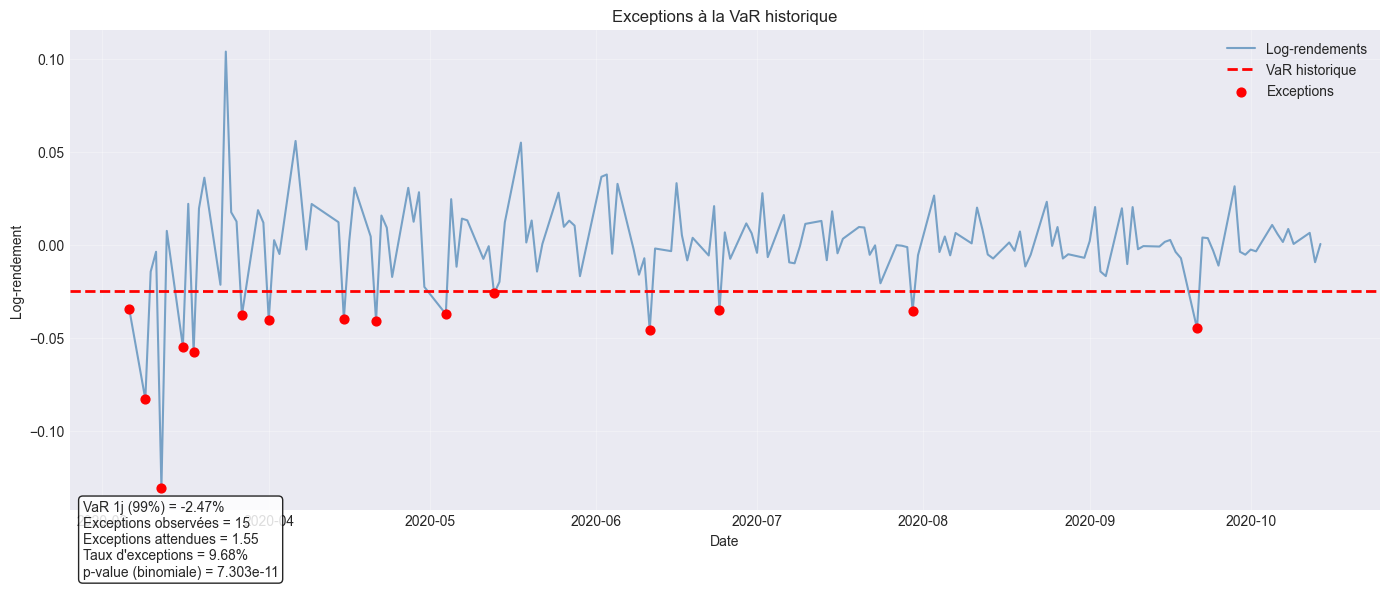

In [34]:
plot_exceptions(test.returns,alpha=0.99, var= var_hist,name='historique')

# 2.	VaR gaussienne

In [35]:
def VaR_Gauss(x, alpha, mu=None, sigma=None):
    """
    Calcule la Value at Risk (VaR) paramétrique gaussienne.
    
    Paramètres:
    -----------
    x : array-like
        Série des rendements logaritmiques
    alpha : float
        Niveau de confiance (ex: 0.95 pour 95%, 0.99 pour 99%)
    mu : float, optionnel
        Moyenne des rendements (si None, calculée à partir de x)
    sigma : float, optionnel
        Écart-type des rendements (si None, calculé à partir de x)

    Retourne:
    ---------
    float : VaR gaussienne au niveau alpha
    """
    # Conversion en array numpy et nettoyage
    x = np.asarray(x).flatten()
    x_clean = x[~np.isnan(x)]
    
    # Calcul des paramètres si non fournis
    if mu is None:
        mu = np.mean(x_clean)
    
    if sigma is None:
        sigma = np.std(x_clean, ddof=1)  # ddof=1 pour estimation non biaisée
    
    # Quantile de la distribution normale standard
    z_alpha = stats.norm.ppf(1 - alpha)
    
    # Formule de la VaR gaussienne
    var_gauss = mu + z_alpha * sigma
    
    return var_gauss,mu,sigma

In [36]:
var_gauss, mu,sigma = VaR_Gauss(train['returns'], alpha)
print(f'VaR gaussienne : {var_gauss:.6f}')

VaR gaussienne : -0.020468


### c.	Faire une validation ex-ante (analyses graphiques, QQ-plot, etc.)
Plusieurs tests de normalité (Shapiro–Wilk, Jarque–Bera, D’Agostino–Pearson, Anderson–Darling et Kolmogorov–Smirnov) sont utilisés afin d’évaluer la pertinence de l’hypothèse gaussienne, en portant une attention particulière au comportement en queue de distribution

In [37]:
def ex_ante_validation_gaussian(x, nom_variable='Returns'):
    """
    Ajuste une distribution gaussienne à un vecteur x
    et réalise plusieurs tests statistiques de normalité.
    """

    x = np.asarray(x)
    x = x[~np.isnan(x)]
    n = len(x)

    # 1. Estimation des paramètres
    mu_estime = np.mean(x)
    sigma_estime = np.std(x, ddof=1)

    print("\nVALIDATION EX-ANTE – AJUSTEMENT GAUSSIEN")
    print("=" * 50)
    print(f"Variable : {nom_variable}")
    print(f"Taille échantillon : n = {n}")
    print(f"μ estimé = {mu_estime:.6f}")
    print(f"σ estimé = {sigma_estime:.6f}")

    # 2. Tests de normalité
    print("\nTESTS DE NORMALITÉ")
    print("-" * 50)

    # Shapiro-Wilk
    shapiro_stat, shapiro_p = stats.shapiro(x)
    print(f"Shapiro-Wilk      : stat = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")

    # Jarque-Bera
    jb_stat, jb_p = stats.jarque_bera(x)
    print(f"Jarque-Bera       : stat = {jb_stat:.4f}, p-value = {jb_p:.4f}")

    # D’Agostino-Pearson
    dag_stat, dag_p = stats.normaltest(x)
    print(f"D'Agostino-Pearson: stat = {dag_stat:.4f}, p-value = {dag_p:.4f}")

    # Anderson-Darling
    ad_result = stats.anderson(x, dist='norm')
    print("Anderson-Darling  :")
    print(f"  Statistique AD  = {ad_result.statistic:.4f}")
    for sl, cv in zip(ad_result.significance_level, ad_result.critical_values):
        decision = "Rejet" if ad_result.statistic > cv else "Non-rejet"
        print(f"  α = {sl:>4.1f}% | CV = {cv:.4f} → {decision}")

    # Kolmogorov-Smirnov
    ks_stat, ks_p = stats.kstest(x, 'norm', args=(mu_estime, sigma_estime))
    print(f"Kolmogorov-Smirnov: stat = {ks_stat:.4f}, p-value = {ks_p:.4f}")

    # 3. Graphiques
    fig = plt.figure(figsize=(14, 9))

    # Histogramme + densité gaussienne
    ax1 = plt.subplot(2, 2, 1)
    n_bins = min(50, int(np.sqrt(n)))
    ax1.hist(x, bins=n_bins, density=True, alpha=0.6,
             edgecolor='black', label='Histogramme')

    x_grid = np.linspace(x.min() - sigma_estime, x.max() + sigma_estime, 1000)
    pdf_gauss = stats.norm.pdf(x_grid, mu_estime, sigma_estime)
    ax1.plot(x_grid, pdf_gauss, 'r-', lw=2, label='Densité gaussienne')

    ax1.set_title(f'Histogramme et densité – {nom_variable}')
    ax1.set_xlabel('Valeur')
    ax1.set_ylabel('Densité')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # QQ-plot
    ax2 = plt.subplot(2, 2, 2)
    stats.probplot(x, dist="norm", plot=ax2)
    ax2.set_title('QQ-plot vs loi normale')
    ax2.grid(alpha=0.3)

    # Fonction de répartition
    ax3 = plt.subplot(2, 2, 3)
    x_sorted = np.sort(x)
    fdr_emp = np.arange(1, n + 1) / n
    fdr_theo = stats.norm.cdf(x_sorted, mu_estime, sigma_estime)

    ax3.step(x_sorted, fdr_emp, where='post', lw=2, label='FDR empirique')
    ax3.plot(x_sorted, fdr_theo, 'r--', lw=2, label='FDR gaussienne')
    ax3.set_title('Fonction de répartition')
    ax3.set_xlabel('Valeur')
    ax3.set_ylabel('F(x)')
    ax3.legend()
    ax3.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        'mu': mu_estime,
        'sigma': sigma_estime,
        'n': n,
        'shapiro_stat': shapiro_stat,
        'shapiro_p': shapiro_p,
        'jb_stat': jb_stat,
        'jb_p': jb_p,
        'dagostino_stat': dag_stat,
        'dagostino_p': dag_p,
        'ad_stat': ad_result.statistic,
        'ks_stat': ks_stat,
        'ks_p': ks_p
    }



VALIDATION EX-ANTE – AJUSTEMENT GAUSSIEN
Variable : Returns
Taille échantillon : n = 926
μ estimé = 0.000244
σ estimé = 0.008903

TESTS DE NORMALITÉ
--------------------------------------------------
Shapiro-Wilk      : stat = 0.9754, p-value = 0.0000
Jarque-Bera       : stat = 161.0101, p-value = 0.0000
D'Agostino-Pearson: stat = 67.6190, p-value = 0.0000
Anderson-Darling  :
  Statistique AD  = 5.7140
  α = 15.0% | CV = 0.5740 → Rejet
  α = 10.0% | CV = 0.6530 → Rejet
  α =  5.0% | CV = 0.7840 → Rejet
  α =  2.5% | CV = 0.9140 → Rejet
  α =  1.0% | CV = 1.0870 → Rejet
Kolmogorov-Smirnov: stat = 0.0679, p-value = 0.0004


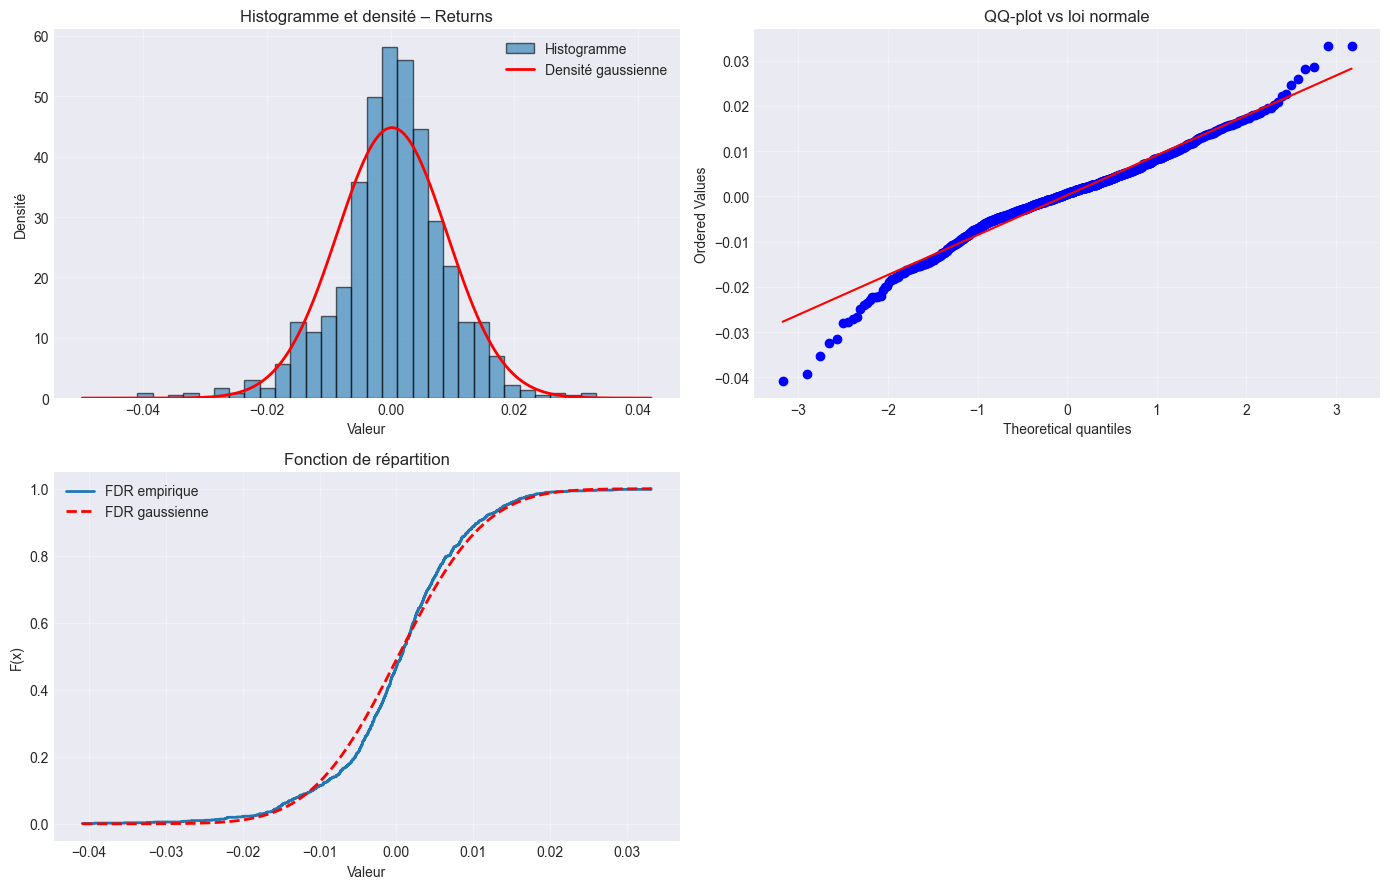

{'mu': np.float64(0.00024359689828045553),
 'sigma': np.float64(0.008902960892197236),
 'n': 926,
 'shapiro_stat': np.float64(0.9754302376717093),
 'shapiro_p': np.float64(2.160737665793983e-11),
 'jb_stat': np.float64(161.01006825498064),
 'jb_p': np.float64(1.0892007030611959e-35),
 'dagostino_stat': np.float64(67.61900522838515),
 'dagostino_p': np.float64(2.073574191185914e-15),
 'ad_stat': np.float64(5.714021678158133),
 'ks_stat': np.float64(0.0679194250428885),
 'ks_p': np.float64(0.0003698982162607956)}

In [38]:
ex_ante_validation_gaussian(train['returns'])

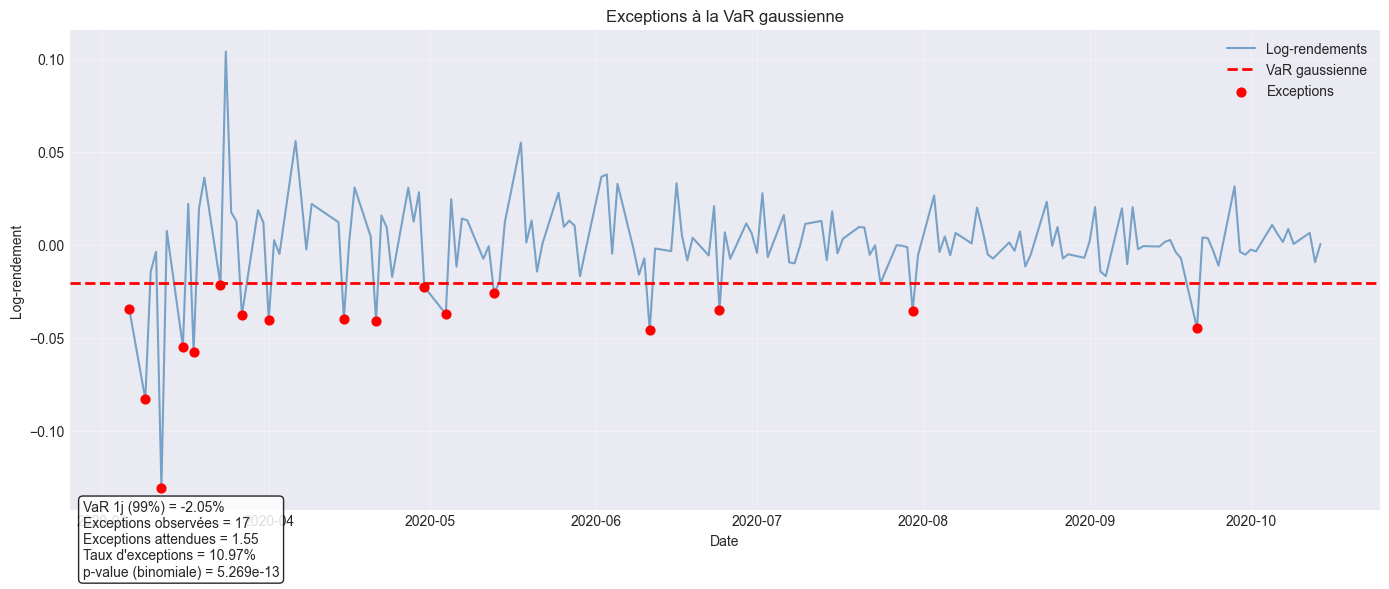

In [39]:
plot_exceptions(test.returns,alpha=0.99, var= var_gauss,name='gaussienne')

## e	Calculer la VaR gaussienne à 10j par méthode de diffusion d’un actif.
La VaR gaussienne à 10 jours est obtenue par la méthode du scaling, reposant sur l’hypothèse d’indépendance et de normalité des rendements, impliquant une croissance de la volatilité proportionnelle à la racine du temps.

On suppose que le prix de l’actif suit un processus de diffusion géométrique :

$$
dS_t = S_t \mu \, dt + S_t \sigma \sqrt{dt}\, Z_t,
\qquad Z_t \sim \mathcal{N}(0,1)
$$

Dans ce cadre, le log-prix suit un mouvement brownien avec dérive. Le log-rendement cumulé sur un horizon de $T$ jours vérifie alors :

$$
R_T =
\log S_{T} - \log S_0
\sim \mathcal{N}\left(
T\mu - \tfrac{1}{2} \cdot T \sigma^2,
\; T \sigma^2
\right)
$$

Donc :
$$
VaR_T^\alpha = T\mu - \tfrac{1}{2} \cdot T \sigma^2 + \sqrt T \sigma q_\alpha
$$

In [40]:
def VaR_Gauss_Diffusion(x, alpha=0.99, T=10):
    """
    VaR gaussienne à T jours par diffusion géométrique

    x     : série de log-rendements (1 jour)
    alpha : niveau de confiance
    T     : horizon (jours)
    """

    x = np.asarray(x)
    mu = np.mean(x)
    sigma = np.std(x, ddof=1)

    z_alpha = norm.ppf(alpha)

    var_T = -(
        T * mu
        - 0.5 * T * sigma**2
        + np.sqrt(T) * sigma * z_alpha
    )

    return var_T


In [41]:
VaR_10j =  VaR_Gauss_Diffusion(train.returns, alpha=0.99, T=10)
print(f"VaR gaussienne à 10 jours (diffusion) : {VaR_10j:.4%}")


VaR gaussienne à 10 jours (diffusion) : -6.7535%


In [42]:
# VaR 10 jours (scaling)
var_10j = np.sqrt(10) * var_gauss
print(f"VaR gaussienne, scaling à 10 jours (99%) : {var_10j:.4%}")

VaR gaussienne, scaling à 10 jours (99%) : -6.4725%


In [43]:
def VaR_Gauss_EWMA(x, alpha=0.99, lam=0.94):
    """
    VaR gaussienne à 1 jour avec EWMA

    x     : série de log-rendements (ordre chronologique)
    alpha : niveau de confiance
    lam   : paramètre lambda (0 < lam < 1)
    """

    x = np.asarray(x)
    T = len(x) - 1

    # Poids EWMA (i = 0 correspond à l'observation la plus récente)
    weights = np.array([(1 - lam) * lam**i for i in range(T + 1)])

    # Normalisation
    weights = weights / weights.sum()

    # Rendements récents en premier
    x_rev = x[::-1]

    # Moyenne pondérée
    mu_hat = np.sum(weights * x_rev)

    # Variance pondérée
    sigma2_hat = np.sum(weights * (x_rev - mu_hat)**2)
    sigma_hat = np.sqrt(sigma2_hat)

    # Quantile gaussien
    z_alpha = norm.ppf(1-alpha)

    # VaR EWMA 1 jour
    var_ewma = mu_hat + sigma_hat * z_alpha

    return var_ewma, mu_hat, sigma_hat


## f. La VaR gaussienne EWMA


La méthode EWMA (Exponential Weighting Moving Average) consiste à estimer les paramètres de la loi gaussienne des rendements en surpondérant les observations les plus récentes à l’aide de poids exponentiellement décroissants. Cette approche permet de rendre la VaR plus réactive aux changements récents de volatilité du marché.

La VaR gaussienne à 1 jour est alors calculée à partir de la moyenne et de l’écart-type pondérés estimés par EWMA.

---

### Résultats – VaR gaussienne EWMA (1 jour, α = 99 %)

| λ    | μ̂(λ)      | σ̂²(λ)     | VaR EWMA 1j (99 %) |
|-----:|-----------:|-----------:|-------------------:|
| 0.90 | -0.006993  | 0.000277   | -4.5723 % |
| 0.95 | -0.004452  | 0.000224   | -3.9291 % |
| 0.99 | -0.000627  | 0.000118   | -2.5926 % |


In [44]:
EWMA = {}
for lam in [0.9, 0.95, 0.99]:
    var, mu_hat, sigma_hat = VaR_Gauss_EWMA(train.returns, alpha=0.99, lam=lam)
    print(f"λ = {lam}")
    print(f"  μ̂(λ) = {mu_hat:.6f}")
    print(f"  σ̂²(λ) = {sigma_hat**2:.6f}")
    print(f"  VaR EWMA 1j (99%) = {var:.4%}\n")
    EWMA[lam] = {
        'var':var,
        'mu' : mu_hat,
        'sigma': sigma_hat
    }


λ = 0.9
  μ̂(λ) = -0.006993
  σ̂²(λ) = 0.000277
  VaR EWMA 1j (99%) = -4.5723%

λ = 0.95
  μ̂(λ) = -0.004452
  σ̂²(λ) = 0.000224
  VaR EWMA 1j (99%) = -3.9291%

λ = 0.99
  μ̂(λ) = -0.000627
  σ̂²(λ) = 0.000118
  VaR EWMA 1j (99%) = -2.5926%



In [45]:
alpha = 0.99
for lamb in EWMA :
    var = EWMA[lamb]['var']
    dic = count_exceptions(test.returns,var_value=var,alpha=0.99)
    EWMA[lamb]['n_exceptions'] = dic['n_exceptions']
    EWMA[lamb]['exception_rate'] = dic['exception_rate']
    EWMA[lamb]['expected_exceptions'] = dic['expected_exceptions']
    EWMA[lamb]['binom_test'] =  dic['binom_test']
    




In [46]:
def plot_ewma_exceptions(returns_test, ewma_dict, lambda_):
    """
    Visualise les rendements, la VaR EWMA et les exceptions
    pour une valeur donnée de lambda
    """
    
    stats = ewma_dict[lambda_]
    var = stats['var']
    
    # Identification des exceptions
    exceptions = returns_test[returns_test < var]
    
    plt.figure(figsize=(14, 6))
    
    # Rendements
    plt.plot(returns_test.index, returns_test.values,
             label='Log-rendements', color='steelblue', alpha=0.7)
    
    # VaR
    plt.axhline(var, color='red', linestyle='--',
                linewidth=2, label=f'VaR EWMA (λ={lambda_})')
    
    # Exceptions
    plt.scatter(exceptions.index, exceptions.values,
                color='red', s=40, zorder=3, label='Exceptions')
    
    # Texte statistiques
    textstr = (
        f"λ = {lambda_}\n"
        f"μ̂ = {stats['mu']:.5f}\n"
        f"σ̂ = {stats['sigma']:.5f}\n"
        f"VaR 1j (99%) = {var:.2%}\n"
        f"Exceptions observées = {stats['n_exceptions']}\n"
        f"Exceptions attendues = {stats['expected_exceptions']:.2f}\n"
        f"Taux d'exceptions = {stats['exception_rate']:.2%}\n"
        f"p-value (binomiale) = {stats['binom_test'].pvalue:.4g}"
    )
    
    plt.gca().text(
        0.01, 0.02, textstr,
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.85)
    )
    
    plt.title(f"Exceptions à la VaR gaussienne EWMA (λ = {lambda_})")
    plt.xlabel("Date")
    plt.ylabel("Log-rendement")
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


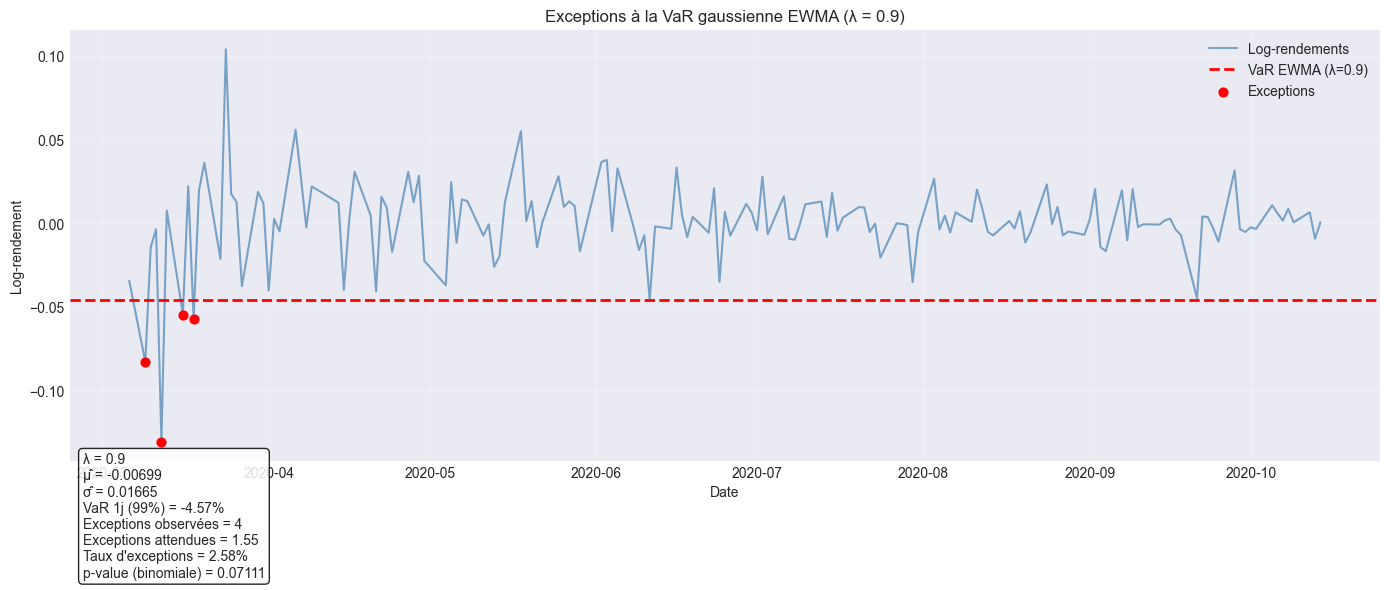

In [47]:
plot_ewma_exceptions(test.returns, EWMA, 0.9)

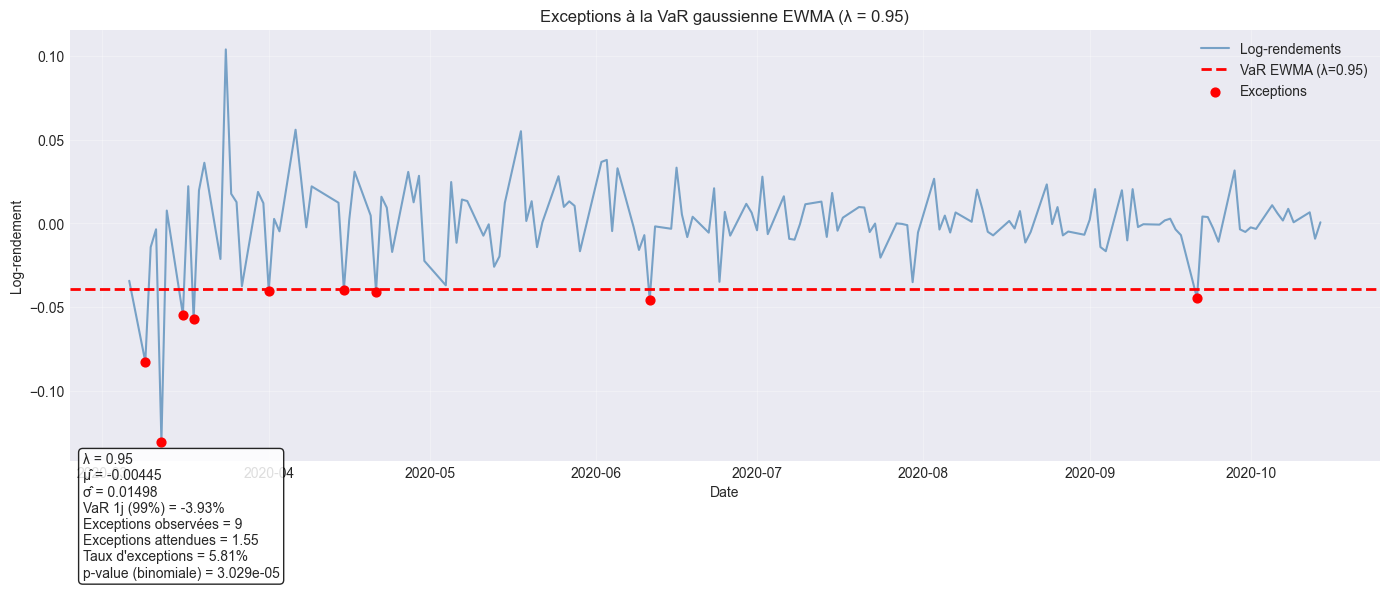

In [48]:
plot_ewma_exceptions(test.returns, EWMA, 0.95)

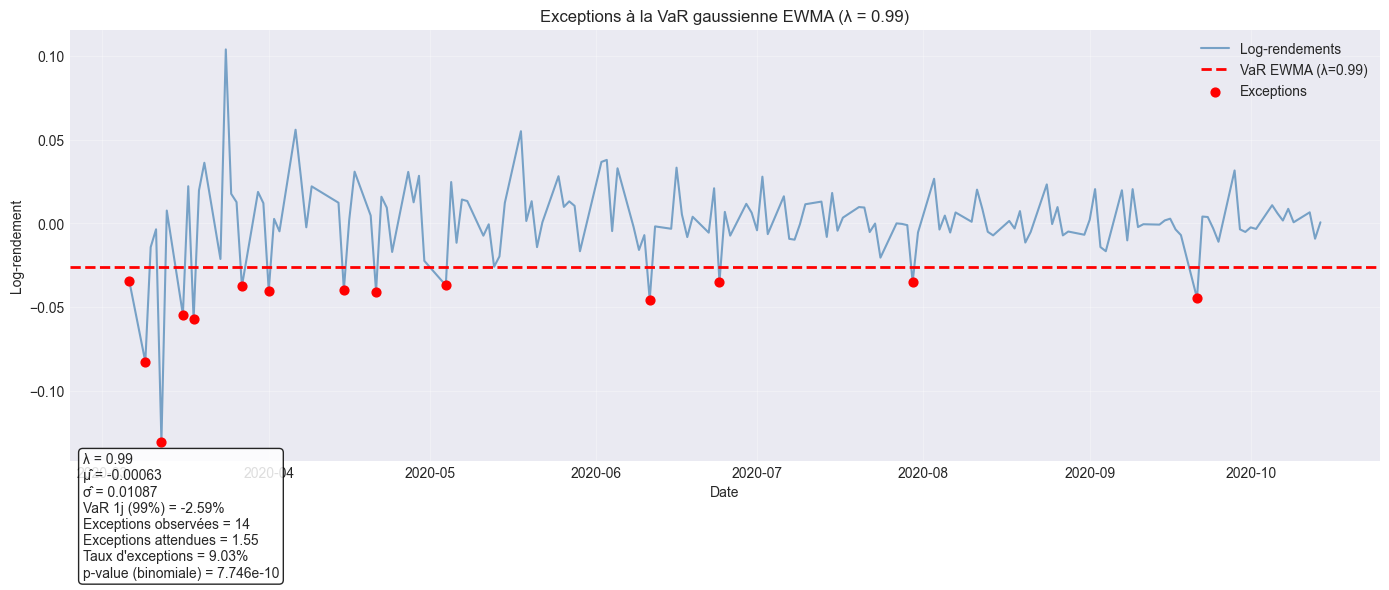

In [49]:
plot_ewma_exceptions(test.returns, EWMA, 0.99)

# 3.	VaR skew-Student

### VaR par loi de Skew-Student

Les rendements financiers présentent généralement une asymétrie et des queues épaisses, ce qui rend l’hypothèse gaussienne souvent inadéquate. Afin de mieux capturer ces caractéristiques, on modélise les log-rendements par une loi de Skew-Student.

La densité de la loi de Skew-Student (Azzalini) s’écrit :
$$
f(x) = \frac{2}{\sigma}
\, t_\nu\!\left( \frac{x-\mu}{\sigma} \right)
\, T_{\nu+1}\!\left(
\alpha \frac{x-\mu}{\sigma}
\sqrt{\frac{\nu+1}{\nu + \left(\frac{x-\mu}{\sigma}\right)^2}}
\right),
$$
où $t_\nu$ désigne la densité de Student à $\nu$ degrés de liberté et $T_{\nu+1}$ sa fonction de répartition.

Les paramètres $\mu$ (localisation), $\sigma$ (échelle), $\nu$ (degrés de liberté) et $\alpha$ (asymétrie) sont estimés par maximum de vraisemblance à partir de l’échantillon d’apprentissage, en maximisant la log-vraisemblance associée à la densité précédente.

La qualité de l’ajustement est évaluée par des outils graphiques, notamment le QQ-plot, et comparée à celle obtenue sous l’hypothèse gaussienne. La VaR à 99 % est ensuite calculée à partir du quantile de la loi de Skew-Student ajustée, permettant une meilleure prise en compte du risque extrême.


In [50]:
def skew_student_pdf(x, mu, sigma, nu, alpha):
    """
    Densité de la loi Skew-Student (Azzalini)
    """
    z = (x - mu) / sigma
    
    t_pdf = stats.t.pdf(z, df=nu)
    t_cdf = stats.t.cdf(
        alpha * z * np.sqrt((nu + 1) / (nu + z**2)),
        df=nu + 1
    )
    
    return 2 / sigma * t_pdf * t_cdf


In [51]:
def skew_student_loglik(params, x):
    """
    Log-vraisemblance de la Skew-Student
    """
    mu, sigma, nu, alpha = params
    
    # Contraintes
    if sigma <= 0 or nu <= 2:
        return np.inf
    
    pdf_vals = skew_student_pdf(x, mu, sigma, nu, alpha)
    
    # Sécurité numérique
    if np.any(pdf_vals <= 0):
        return np.inf
    
    return -np.sum(np.log(pdf_vals))


In [52]:
def estimate_skew_student_mle(x,init_params=None):
    """
    Estimation MLE des paramètres Skew-Student
    """
    if not init_params:
        # Initialisation raisonnable
        mu0 = np.mean(x)
        sigma0 = np.std(x)
        nu0 = 8.0
        alpha0 = 0.0
        
        init_params = [mu0, sigma0, nu0, alpha0]
        
    bounds = [
        (None, None),   # mu
        (1e-6, None),   # sigma
        (2.01, 100),    # nu
        (None, None)    # alpha
    ]
    
    result = minimize(
        skew_student_loglik,
        init_params,
        args=(x,),
        method='L-BFGS-B',
        bounds=bounds
    )
    
    if not result.success:
        raise RuntimeError("Optimisation échouée")
    
    mu_hat, sigma_hat, nu_hat, alpha_hat = result.x
    print(result.message)
    print('Convergence?:', result.success)
    
    return {
        'mu': mu_hat,
        'sigma': sigma_hat,
        'nu': nu_hat,
        'alpha': alpha_hat,
        'loglik': -result.fun
    }


## b.	Estimer les paramètres de loi Skew Student sur base d’apprentissage

In [53]:
params_skew = estimate_skew_student_mle(train.returns)

params_skew


CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Convergence?: True


{'mu': np.float64(0.00048603702741480224),
 'sigma': np.float64(0.007491117217702084),
 'nu': np.float64(8.00000001556615),
 'alpha': np.float64(-9.95351341535208e-07),
 'loglik': np.float64(3086.0405449312134)}

## Validation ex-ante – QQ-plot Skew-Student

La validation ex-ante du modèle Skew-Student est réalisée à l’aide d’un QQ-plot, qui compare les quantiles empiriques des log-rendements observés aux quantiles théoriques de la loi de Skew-Student ajustée sur l’échantillon d’apprentissage.

Si le modèle est bien spécifié, les points du QQ-plot doivent être approximativement alignés sur la droite de référence. Les écarts observés dans les queues permettent d’évaluer la capacité du modèle à capturer les comportements extrêmes, élément essentiel dans le cadre du calcul de la Value-at-Risk.

Les quantiles théoriques de la loi de Skew-Student ne disposant pas d’expression analytique fermée, ceux-ci sont approchés par simulation Monte-Carlo à partir d’une construction asymétrique de la loi de Student.



In [54]:
def qqplot_skew_student(x, params):
    """
    QQ-plot pour la loi Skew-Student
    """
    mu = params['mu']
    sigma = params['sigma']
    nu = params['nu']
    alpha = params['alpha']
    
    # Quantiles empiriques
    x_sorted = np.sort(x)
    n = len(x_sorted)
    probs = (np.arange(1, n + 1) - 0.5) / n
    
    # Quantiles théoriques via simulation
    # (plus stable qu'une inversion analytique)
    sim = stats.t.rvs(df=nu, size=200000)
    sim = mu + sigma * (sim + alpha * np.abs(sim))
    q_theoretical = np.quantile(sim, probs)
    
    # QQ-plot
    plt.figure(figsize=(6, 6))
    plt.scatter(q_theoretical, x_sorted, alpha=0.6)
    plt.plot(
        [q_theoretical.min(), q_theoretical.max()],
        [q_theoretical.min(), q_theoretical.max()],
        'r--', linewidth=2
    )
    
    plt.xlabel("Quantiles théoriques Skew-Student")
    plt.ylabel("Quantiles empiriques")
    plt.title("QQ-plot – Validation ex-ante Skew-Student")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


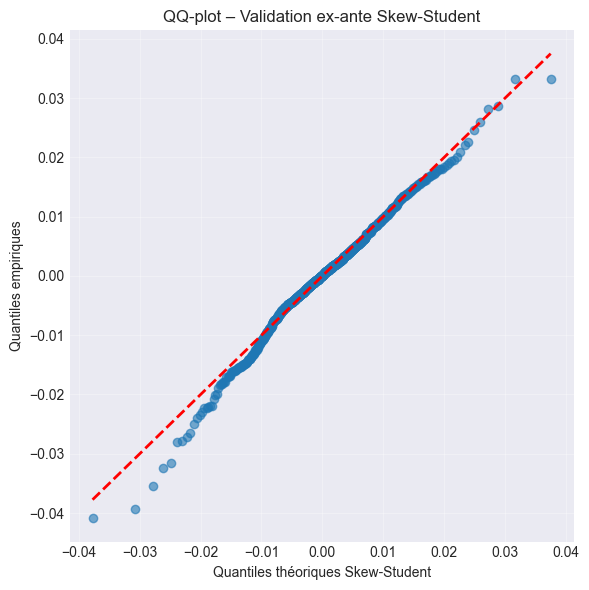

In [55]:
qqplot_skew_student(train.returns, params_skew)


Des écarts sont observés dans les quantiles extrêmes, suggérant une sous-estimation du risque de queue. Néanmoins, la loi de Skew-Student améliore significativement l’ajustement par rapport à l’hypothèse gaussienne.


### Comparaison de la qualité d’ajustement : Gaussienne vs Skew-Student

La qualité d’ajustement des modèles gaussien et Skew-Student est comparée à l’aide d’outils graphiques. Les densités théoriques ajustées sont superposées à l’histogramme des log-rendements, et les QQ-plots correspondants sont analysés.

La loi gaussienne permet de capturer le comportement central des rendements mais sous-estime généralement l’épaisseur des queues. À l’inverse, la loi de Skew-Student offre une meilleure flexibilité grâce à ses paramètres d’asymétrie et de degrés de liberté, permettant un meilleur ajustement des rendements extrêmes.


In [56]:
def compare_densities_gauss_skew(x, params_gauss, params_skew):
    """
    Comparaison graphique des densités gaussienne et Skew-Student
    """
    mu_g, sigma_g = params_gauss['mu'], params_gauss['sigma']
    
    mu_s = params_skew['mu']
    sigma_s = params_skew['sigma']
    nu_s = params_skew['nu']
    alpha_s = params_skew['alpha']
    
    x_grid = np.linspace(np.min(x), np.max(x), 1000)
    
    # Histogramme
    plt.figure(figsize=(10, 6))
    plt.hist(x, bins=40, density=True, alpha=0.5,
             label='Histogramme des rendements')
    
    # Densité gaussienne
    plt.plot(
        x_grid,
        stats.norm.pdf(x_grid, mu_g, sigma_g),
        'r--', linewidth=2, label='Gaussienne'
    )
    
    # Densité Skew-Student
    from scipy.stats import t
    
    z = (x_grid - mu_s) / sigma_s
    pdf_skew = (
        2 / sigma_s
        * t.pdf(z, df=nu_s)
        * t.cdf(
            alpha_s * z * np.sqrt((nu_s + 1) / (nu_s + z**2)),
            df=nu_s + 1
        )
    )
    
    plt.plot(
        x_grid,
        pdf_skew,
        'g-', linewidth=2, label='Skew-Student'
    )
    
    plt.title("Comparaison des densités ajustées")
    plt.xlabel("Log-rendement")
    plt.ylabel("Densité")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [57]:
def qqplot_gauss_vs_skew(x, params_gauss, params_skew):
    """
    QQ-plots comparés Gaussienne vs Skew-Student
    """
    x_sorted = np.sort(x)
    n = len(x_sorted)
    probs = (np.arange(1, n + 1) - 0.5) / n
    
    # Gaussienne
    q_gauss = stats.norm.ppf(probs, params_gauss['mu'], params_gauss['sigma'])
    
    # Skew-Student (simulation)
    sim = stats.t.rvs(df=params_skew['nu'], size=200000)
    sim = params_skew['mu'] + params_skew['sigma'] * (
        sim + params_skew['alpha'] * np.abs(sim)
    )
    q_skew = np.quantile(sim, probs)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # QQ Gauss
    axes[0].scatter(q_gauss, x_sorted, alpha=0.6)
    axes[0].plot(
        [q_gauss.min(), q_gauss.max()],
        [q_gauss.min(), q_gauss.max()],
        'r--'
    )
    axes[0].set_title("QQ-plot Gaussienne")
    axes[0].set_xlabel("Quantiles théoriques")
    axes[0].set_ylabel("Quantiles empiriques")
    axes[0].grid(alpha=0.3)
    
    # QQ Skew
    axes[1].scatter(q_skew, x_sorted, alpha=0.6)
    axes[1].plot(
        [q_skew.min(), q_skew.max()],
        [q_skew.min(), q_skew.max()],
        'r--'
    )
    axes[1].set_title("QQ-plot Skew-Student")
    axes[1].set_xlabel("Quantiles théoriques")
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


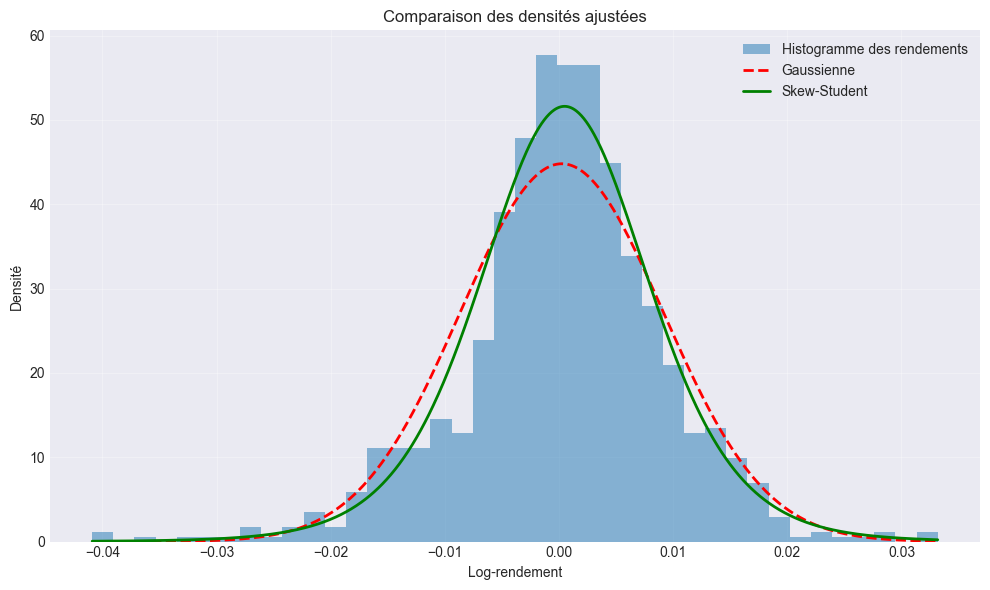

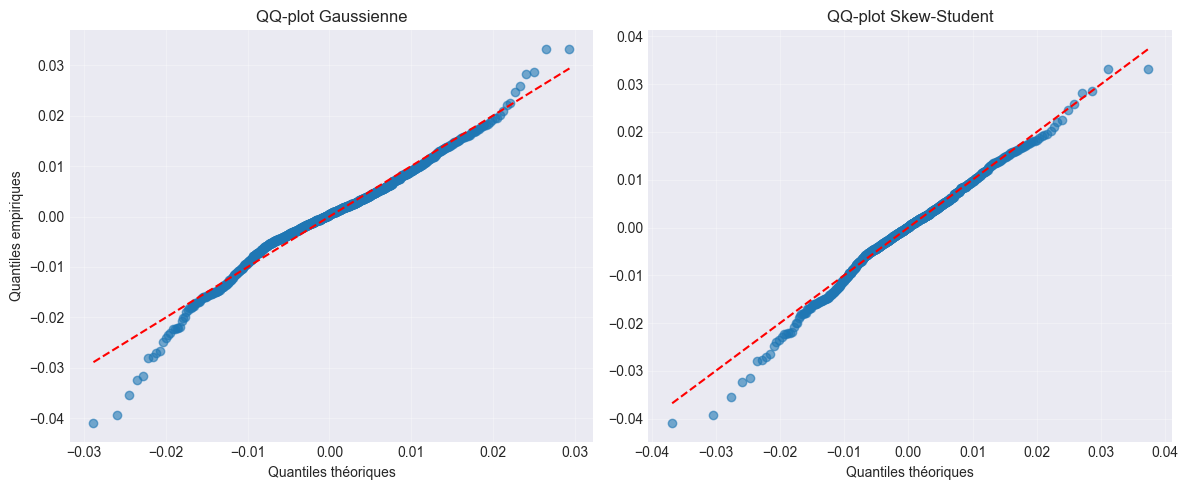

In [58]:
params_gauss ={}
params_gauss['mu'], params_gauss['sigma'] = mu, sigma
compare_densities_gauss_skew(train.returns, params_gauss, params_skew)
qqplot_gauss_vs_skew(train.returns, params_gauss, params_skew)

L’analyse graphique met en évidence une nette amélioration de la qualité d’ajustement avec la loi de Skew-Student. Alors que le modèle gaussien sous-estime les quantiles extrêmes, la Skew-Student permet de mieux reproduire l’asymétrie et l’épaisseur des queues observées dans les rendements, ce qui justifie son utilisation pour le calcul de la Value-at-Risk.


## e.	Calculer la VaR Skew Student sur base d’apprentissage pour alpha = 99%.

In [59]:
def var_skew_student(params,alpha = 0.99,size=200000):
    """
    QQ-plot pour la loi Skew-Student
    """

    mu = params['mu']
    sigma = params['sigma']
    nu = params['nu']
    alpha_t = params['alpha']
    
    # Quantiles théoriques via simulation
    # (plus stable qu'une inversion analytique)
    sim = stats.t.rvs(df=nu, size=size)
    sim = mu + sigma * (sim + alpha_t * np.abs(sim))
    var = np.quantile(sim, 1-alpha)
    return var

In [60]:
var_skew_t = var_skew_student(params_skew,alpha = 0.99,size=200000)

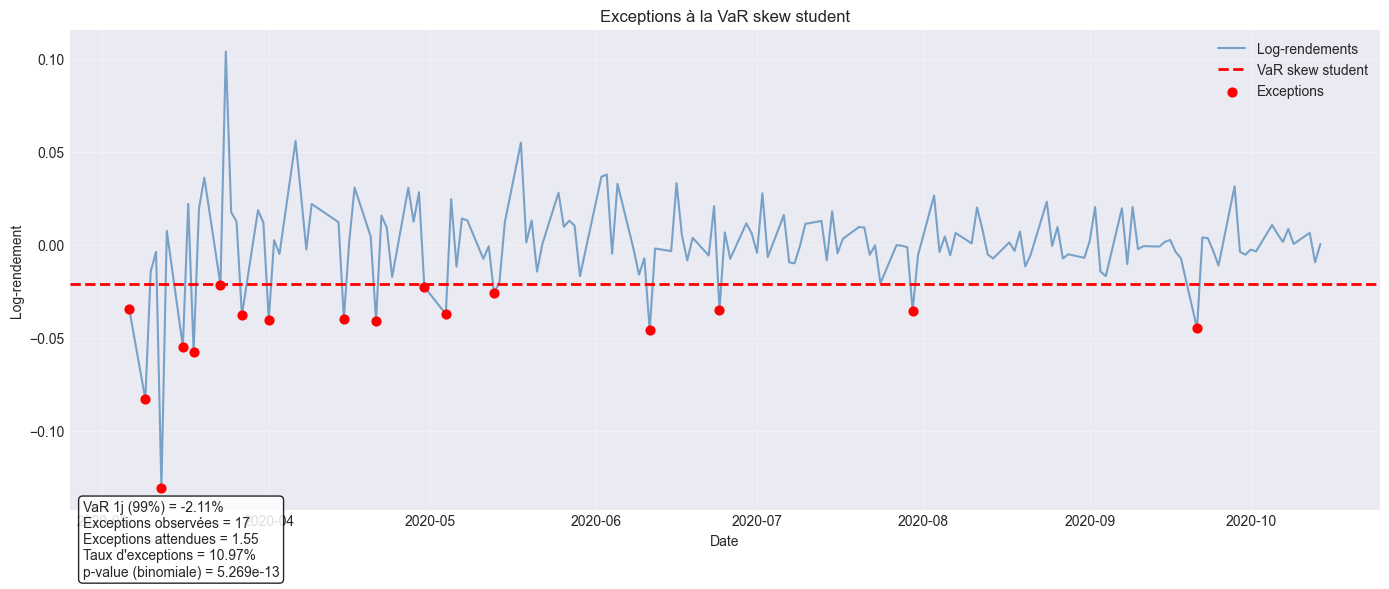

In [61]:
plot_exceptions(test.returns,alpha=0.99, var= var_skew_t,name='skew student')

# KDE

In [62]:
def kde_gaussien_complet(x, nom_variable="returns", bandwidth=None):
    """
    Estimation par noyaux gaussiens (Kernel Density Estimation)
    avec noyau gaussien et sélection automatique de la bande passante
    """
    
    n = len(x)
    mu_emp = np.mean(x)
    sigma_emp = np.std(x)
    
    print(f"KDE AVEC NOYAU GAUSSIEN - {nom_variable}")
    print(f"Moyenne empirique: {mu_emp:.6f}")
    print(f"Écart-type empirique: {sigma_emp:.6f}")
    print(f"Médiane: {np.median(x):.6f}")
    print(f"Min: {np.min(x):.6f}, Max: {np.max(x):.6f}")
    print(f"IQR: {np.percentile(x, 75) - np.percentile(x, 25):.6f}")
    
    # Création de l'objet KDE
    if bandwidth is None:
        # Règle de Silverman pour la bande passante
        h_silverman = 1.06 * sigma_emp * n**(-1/5)
        bandwidth = h_silverman
    
    kde = stats.gaussian_kde(x, bw_method=bandwidth/sigma_emp if sigma_emp > 0 else 0.1)
    kde_bandwidth = kde.factor * sigma_emp if sigma_emp > 0 else kde.factor
    
    print(f"\nPARAMÈTRES KDE:")
    print(f"Bande passante (bandwidth): {kde_bandwidth:.6f}")
    print(f"Bande passante relative (factor): {kde.factor:.6f}")
    print(f"Méthode: Noyau gaussien")
    
    # Calcul sur une grille
    x_min, x_max = np.min(x) - 3*kde_bandwidth, np.max(x) + 3*kde_bandwidth
    x_grid = np.linspace(x_min, x_max, 1000)
    kde_values = kde(x_grid)
    
    # Calcul de moments à partir de KDE
    def moments_from_kde(kde_obj, n_moments=4):
        """Calcule les moments à partir de la densité KDE"""
        # On utilise l'intégration numérique
        x_integ = np.linspace(x_min, x_max, 2000)
        pdf_integ = kde_obj(x_integ)
        dx = x_integ[1] - x_integ[0]
        
        # Normalisation
        norm = np.sum(pdf_integ) * dx
        
        if norm > 0:
            # Moyenne
            mean_kde = np.sum(x_integ * pdf_integ) * dx / norm
            
            # Variance
            var_kde = np.sum((x_integ - mean_kde)**2 * pdf_integ) * dx / norm
            
            # Skewness
            skew_kde = np.sum((x_integ - mean_kde)**3 * pdf_integ) * dx / norm / (var_kde**1.5)
            
            # Kurtosis
            kurt_kde = np.sum((x_integ - mean_kde)**4 * pdf_integ) * dx / norm / (var_kde**2)
            
            return mean_kde, var_kde, skew_kde, kurt_kde
        return None, None, None, None
    
    mean_kde, var_kde, skew_kde, kurt_kde = moments_from_kde(kde)
    
    if mean_kde is not None:
        print(f"\nMOMENTS ESTIMÉS PAR KDE:")
        print(f"Moyenne KDE: {mean_kde:.6f}")
        print(f"Variance KDE: {var_kde:.6f} (σ = {np.sqrt(var_kde):.6f})")
        print(f"Asymétrie KDE: {skew_kde:.6f}")
        print(f"Kurtosis KDE: {kurt_kde:.6f}")
    
    # 2. Graphiques
    fig = plt.figure(figsize=(15, 10))
    
    # 2a. Comparaison avec histogramme et densité normale
    ax1 = plt.subplot(2, 2, 1)
    
    # Histogramme
    n_bins = min(50, int(np.sqrt(n)))
    ax1.hist(x, bins=n_bins, density=True, alpha=0.3, color='gray', 
             edgecolor='black', label='Histogramme')
    
    # KDE
    ax1.plot(x_grid, kde_values, 'b-', linewidth=3, label=f'KDE (h={kde_bandwidth:.3f})')
    
    # Densité normale
    pdf_norm = stats.norm.pdf(x_grid, loc=mu_emp, scale=sigma_emp)
    ax1.plot(x_grid, pdf_norm, 'r--', linewidth=2, alpha=0.7, label='Normale empirique')
    
    # Points de données (rug plot)
    ax1.plot(x, np.zeros_like(x) - 0.001, '|', color='black', alpha=0.1, markersize=10)
    
    ax1.set_xlabel('Valeur')
    ax1.set_ylabel('Densité')
    ax1.set_title(f'Estimation par noyaux gaussiens - {nom_variable}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2b. Effet de la bande passante
    ax2 = plt.subplot(2, 2, 2)
    
    # Différentes bandes passantes
    bandwidths = [kde_bandwidth * 0.5, kde_bandwidth, kde_bandwidth * 2]
    colors = ['green', 'blue', 'red']
    labels = [f'h={h:.3f}' for h in bandwidths]
    
    for h, color, label in zip(bandwidths, colors, labels):
        kde_temp = stats.gaussian_kde(x, bw_method=h/sigma_emp if sigma_emp > 0 else h)
        ax2.plot(x_grid, kde_temp(x_grid), color=color, linewidth=2, 
                label=label, alpha=0.7)
    
    ax2.hist(x, bins=n_bins, density=True, alpha=0.1, color='gray', edgecolor='black')
    ax2.plot(x, np.zeros_like(x) - 0.001, '|', color='black', alpha=0.05, markersize=10)
    
    ax2.set_xlabel('Valeur')
    ax2.set_ylabel('Densité')
    ax2.set_title('Effet de la bande passante')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 2c. Fonction de répartition KDE vs empirique
    ax3 = plt.subplot(2, 2, 3)
    
    # FDR empirique
    x_sorted = np.sort(x)
    fdr_emp = np.arange(1, n + 1) / n
    
    # FDR KDE (intégration numérique)
    fdr_kde = np.zeros_like(x_grid)
    for i in range(len(x_grid)):
        fdr_kde[i] = np.trapz(kde_values[:i+1], x_grid[:i+1])
    
    # Normalisation de la FDR KDE
    fdr_kde = fdr_kde / fdr_kde[-1] if fdr_kde[-1] > 0 else fdr_kde
    
    ax3.step(x_sorted, fdr_emp, 'k-', where='post', linewidth=1, label='FDR empirique')
    ax3.plot(x_grid, fdr_kde, 'b-', linewidth=2, label='FDR KDE')
    
    # FDR normale
    fdr_norm = stats.norm.cdf(x_grid, loc=mu_emp, scale=sigma_emp)
    ax3.plot(x_grid, fdr_norm, 'r--', linewidth=2, alpha=0.7, label='FDR normale')
    
    ax3.set_xlabel('Valeur')
    ax3.set_ylabel('Fonction de répartition')
    ax3.set_title('Fonctions de répartition comparées')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 2d. Analyse des résidus et qualité de l'ajustement
    ax4 = plt.subplot(2, 2, 4)
    
    # Calcul de la FDR KDE aux points empiriques
    fdr_kde_at_points = np.interp(x_sorted, x_grid, fdr_kde)
    residuals = fdr_emp - fdr_kde_at_points
    
    ax4.plot(x_sorted, residuals, 'g-', linewidth=1)
    ax4.fill_between(x_sorted, 0, residuals, where=residuals>0, 
                     alpha=0.3, color='green', label='KDE sous-estime')
    ax4.fill_between(x_sorted, 0, residuals, where=residuals<0, 
                     alpha=0.3, color='red', label='KDE sur-estime')
    ax4.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    
    # Statistique de Kolmogorov-Smirnov
    ks_stat = np.max(np.abs(residuals))
    ax4.axhline(y=ks_stat, color='b', linestyle=':', alpha=0.5, 
                label=f'KS = {ks_stat:.3f}')
    ax4.axhline(y=-ks_stat, color='b', linestyle=':', alpha=0.5)
    
    ax4.set_xlabel('Valeur')
    ax4.set_ylabel('FDR empirique - FDR KDE')
    ax4.set_title(f'Résidus de l\'ajustement KDE')
    ax4.legend(loc='best')
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle(f'KDE avec noyau gaussien - {nom_variable} (n={n}, h={kde_bandwidth:.3f})', 
                 fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # 3. Métriques de performance
    print(f"\nQUALITÉ DE L'AJUSTEMENT KDE:")
    print("-" * 40)
    
    # Intégrated Squared Error (ISE) approximé
    dx = x_grid[1] - x_grid[0]
    
    # Densité empirique (histogramme)
    hist, bin_edges = np.histogram(x, bins=n_bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    pdf_hist = np.interp(x_grid, bin_centers, hist)
    
    ise = np.sum((kde_values - pdf_hist)**2) * dx
    print(f"Integrated Squared Error (ISE): {ise:.6f}")
    
    # Statistique KS
    print(f"Statistique Kolmogorov-Smirnov: {ks_stat:.6f}")
    
    # Score de vraisemblance log
    log_likelihood = np.sum(np.log(kde(x) + 1e-10))
    print(f"Log-vraisemblance: {log_likelihood:.2f}")
    
    # 4. Comparaison avec la distribution normale
    print(f"\nCOMPARAISON KDE vs DISTRIBUTION NORMALE:")
    print("-" * 40)
    
    # Différence intégrée
    diff_integrale = np.sum(np.abs(kde_values - pdf_norm)) * dx
    print(f"Différence intégrée L1: {diff_integrale:.6f}")
    
    # Ratio de vraisemblance
    log_lik_norm = np.sum(stats.norm.logpdf(x, loc=mu_emp, scale=sigma_emp))
    print(f"Log-vraisemblance Normale: {log_lik_norm:.2f}")
    print(f"Différence de log-vraisemblance: {log_likelihood - log_lik_norm:.2f}")
    
    if log_likelihood > log_lik_norm:
        print("→ KDE a une meilleure vraisemblance que la normale")
    else:
        print("→ La normale a une meilleure vraisemblance que KDE")
    
    # 5. Estimation des quantiles avec KDE
    print(f"\nESTIMATION DES QUANTILES PAR KDE:")
    print("-" * 40)
    
    quantiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
    
    print(f"{'Quantile':<10} {'KDE':<12} {'Empirique':<12} {'Normale':<12}")
    print("-" * 50)
    
    for q in quantiles:
        # Quantile empirique
        q_emp = np.percentile(x, q * 100)
        
        # Quantile KDE (par interpolation inverse de la FDR)
        idx = np.argmax(fdr_kde >= q)
        if idx > 0:
            q_kde = x_grid[idx]
        else:
            q_kde = np.interp(q, fdr_kde, x_grid)
        
        # Quantile normale
        q_norm = stats.norm.ppf(q, loc=mu_emp, scale=sigma_emp)
        
        print(f"{q*100:>5.1f}%   {q_kde:11.6f}  {q_emp:11.6f}  {q_norm:11.6f}")
    
    return {
        'kde_object': kde,
        'bandwidth': kde_bandwidth,
        'x_grid': x_grid,
        'kde_values': kde_values,
        'fdr_kde': fdr_kde,
        'mean_kde': mean_kde,
        'var_kde': var_kde,
        'skew_kde': skew_kde,
        'kurt_kde': kurt_kde,
        'log_likelihood': log_likelihood,
        'ks_stat': ks_stat,
        'ise': ise
    }


KDE AVEC NOYAU GAUSSIEN - returns
Moyenne empirique: 0.000244
Écart-type empirique: 0.008898
Médiane: 0.000650
Min: -0.040892, Max: 0.033175
IQR: 0.009459

PARAMÈTRES KDE:
Bande passante (bandwidth): 0.002406
Bande passante relative (factor): 0.270386
Méthode: Noyau gaussien

MOMENTS ESTIMÉS PAR KDE:
Moyenne KDE: 0.000244
Variance KDE: 0.000085 (σ = 0.009218)
Asymétrie KDE: -0.371009
Kurtosis KDE: 4.621223


C:\Users\UltraBook 3.1\AppData\Local\Temp\ipykernel_31396\3862390392.py:132: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  fdr_kde[i] = np.trapz(kde_values[:i+1], x_grid[:i+1])


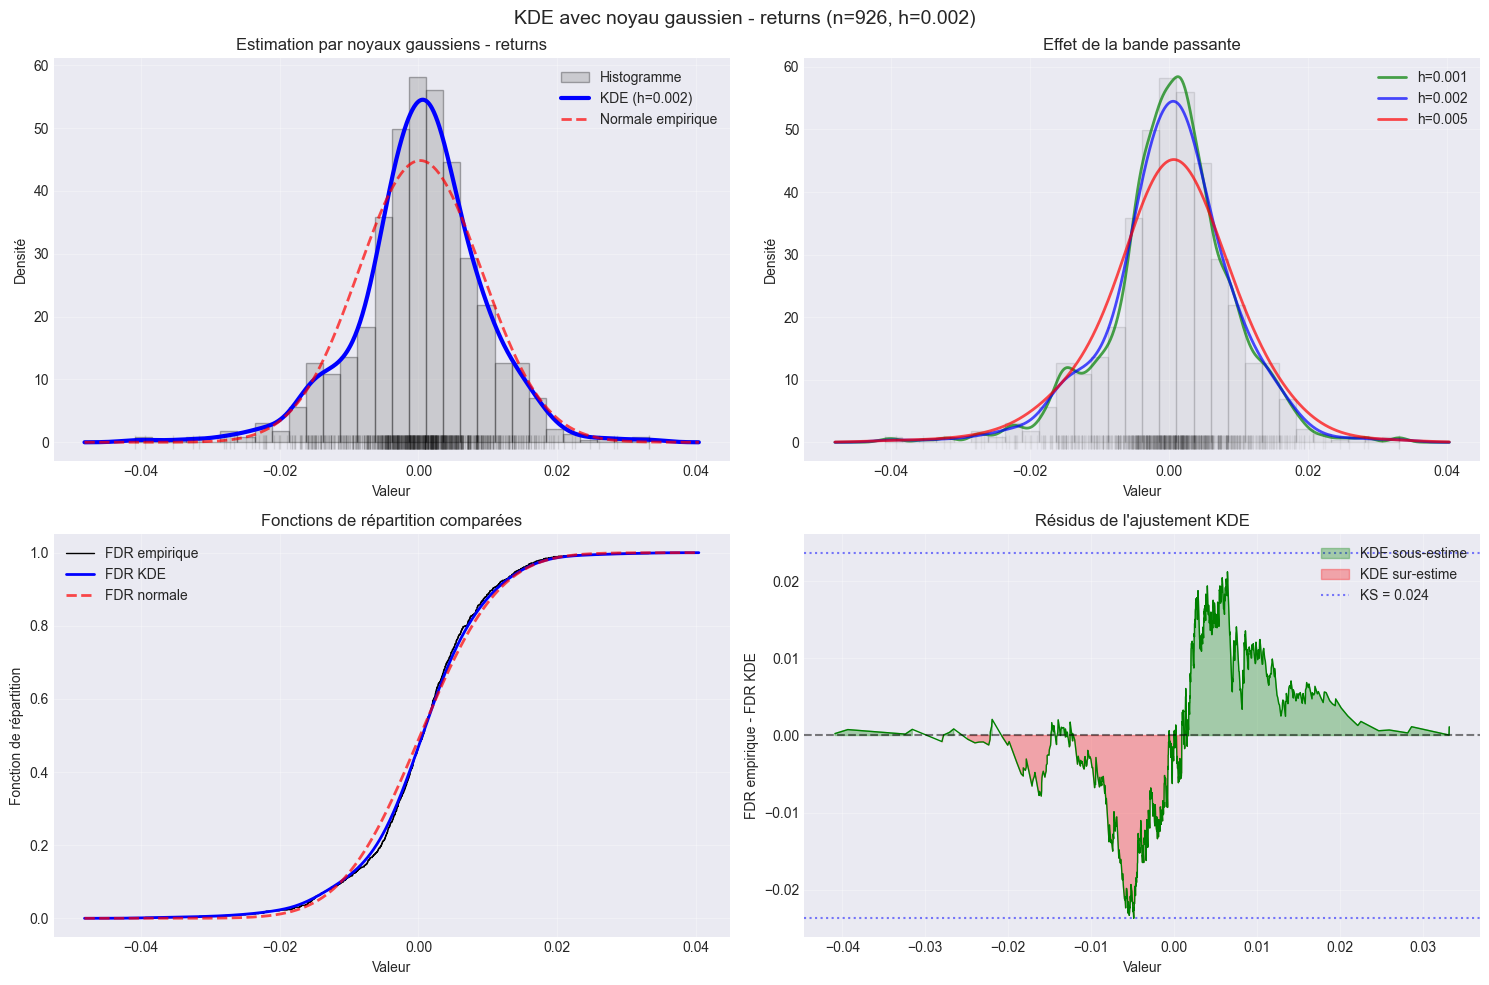


QUALITÉ DE L'AJUSTEMENT KDE:
----------------------------------------
Integrated Squared Error (ISE): 0.137155
Statistique Kolmogorov-Smirnov: 0.023666
Log-vraisemblance: 3103.17

COMPARAISON KDE vs DISTRIBUTION NORMALE:
----------------------------------------
Différence intégrée L1: 0.160009
Log-vraisemblance Normale: 3058.55
Différence de log-vraisemblance: 44.62
→ KDE a une meilleure vraisemblance que la normale

ESTIMATION DES QUANTILES PAR KDE:
----------------------------------------
Quantile   KDE          Empirique    Normale     
--------------------------------------------------
  1.0%     -0.025697    -0.024680    -0.020457
  5.0%     -0.015597    -0.015278    -0.014393
 25.0%     -0.004523    -0.004185    -0.005758
 50.0%      0.000615     0.000650     0.000244
 75.0%      0.005753     0.005273     0.006245
 95.0%      0.014701     0.014091     0.014880
 99.0%      0.021522     0.019978     0.020944


In [63]:
kde = kde_gaussien_complet(train.returns)

In [64]:
alpha = 0.99
sim = kde['kde_object'].resample(100000).flatten()
var_kde = np.quantile(sim, 1-alpha)
print(f'VaR KDE : {var_kde}')

VaR KDE : -0.02560633476573422


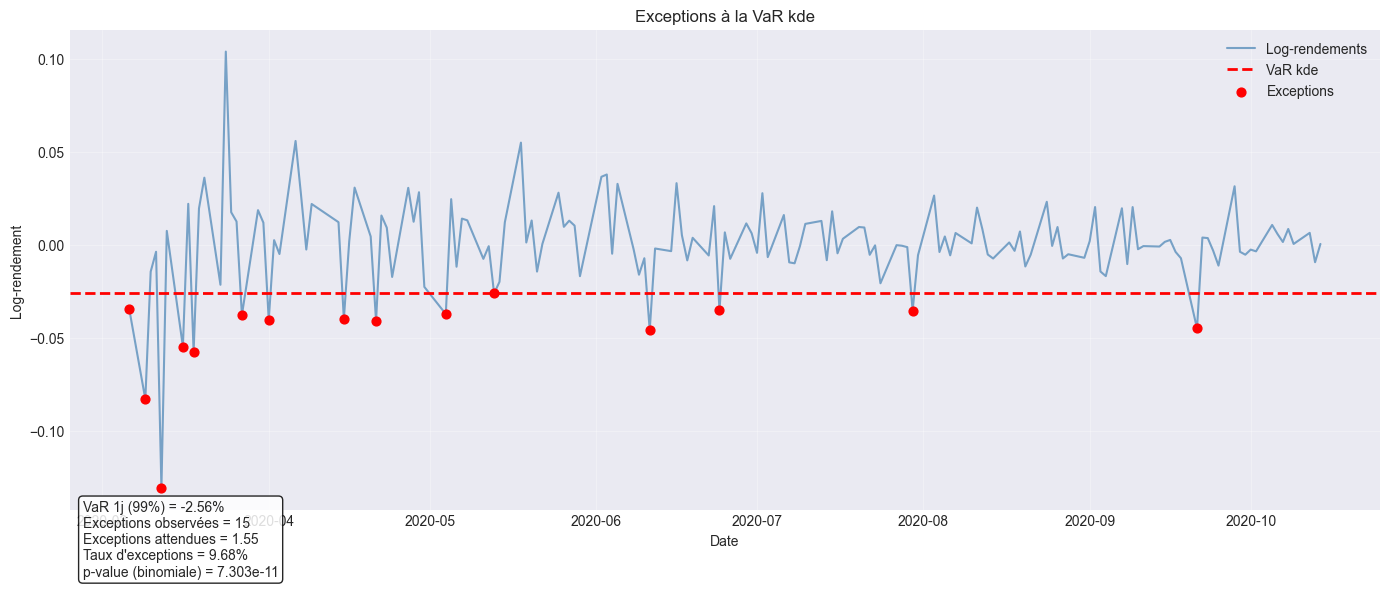

In [65]:
plot_exceptions(test.returns,alpha=0.99, var= var_kde,name='kde')

# 4. Protocole de recalibrage du modèle de VaR

L’objectif est de disposer d’un modèle de Value-at-Risk (VaR) initialement calibré sur une période d’apprentissage, capable d’être backtesté quotidiennement, tout en limitant les recalibrages inutiles. Le recalibrage doit être déclenché uniquement lorsque le modèle devient statistiquement inadapté aux données récentes.


## Protocole de backtesting et de recalibrage adaptatif de la VaR

L’objectif de ce protocole est de mettre en place un cadre opérationnel de backtesting de la Value-at-Risk (VaR) permettant :
- une évaluation quotidienne de la qualité du modèle,
- une détection statistiquement fondée de son inadéquation aux données récentes,
- un recalibrage parcimonieux, évitant des ajustements excessivement fréquents.

---

### 1. Calibration initiale

Le modèle de VaR est initialement calibré sur une période d’apprentissage constituée des rendements historiques. Cette calibration fournit une première estimation de la VaR à un niveau de confiance $ \alpha $ (par exemple 99 %), notée $ \text{VaR}_0 $.

---
### 2. Calcul quotidien de la VaR

À chaque date de la période de test, la VaR à un jour est calculée à partir des paramètres du modèle. Une exception est observée lorsque le rendement réalisé est inférieur à la VaR estimée.

$$
\text{Exception}_t =
\begin{cases}
1 & \text{si } r_t < \text{VaR}_t \\
0 & \text{sinon}
\end{cases}
$$

La validité du modèle est évaluée à l’aide du test de couverture inconditionnelle de Kupiec. Sous l’hypothèse nulle d’un modèle correctement calibré, le nombre d’exceptions suit une loi binomiale de paramètre $1-\alpha$.

Le test permet de vérifier si le taux d’exceptions observé est compatible avec le niveau de risque attendu.

### 2. Backtesting quotidien

À chaque nouvelle observation du jeu de test, le protocole procède aux étapes suivantes :

1. **Évaluation de la VaR courante**  
   La VaR estimée lors de la dernière calibration est comparée au rendement observé.

2. **Test statistique de couverture**  
   La qualité du modèle est évaluée à l’aide d’un test de couverture au niveau de confiance $ \text{niv\_conf} $ (par exemple 95 %). Deux tests peuvent être utilisés :
   
   - **Test de Kupiec (LR$_{uc}$)**  
     Ce test vérifie la couverture inconditionnelle de la VaR, en comparant le taux empirique d’exceptions au taux théorique $ 1 - \alpha $.
   
   - **Test de Christoffersen (LR$_{cc}$)**  
     Ce test étend le test de Kupiec en intégrant un test d’indépendance des exceptions, modélisées comme une chaîne de Markov d’ordre 1. Il permet de détecter un éventuel clustering des exceptions, caractéristique d’un modèle mal spécifié dynamiquement.

3. **Décision journalière**  
   Si le test choisi rejette l’hypothèse nulle de bonne couverture, le modèle est considéré comme temporairement inadapté pour la journée courante.

---

### 3. Critère de persistance et recalibrage

Afin d’éviter des recalibrages trop fréquents dus à des fluctuations aléatoires, un critère de persistance est introduit :

- Un recalibrage n’est déclenché que si le test de couverture est rejeté pendant au moins $ d $ jours consécutifs (paramètre `persistence_days`).
- Lorsque ce seuil est atteint, le modèle est recalibré sur une fenêtre glissante actualisée de rendements récents.
- La nouvelle VaR estimée remplace alors la VaR précédente, et le compteur de persistance est réinitialisé.

---

### 4. Mise à jour de la fenêtre d’apprentissage

Après chaque itération :
- la fenêtre d’apprentissage est mise à jour en supprimant les observations les plus anciennes,
- la nouvelle observation issue du jeu de test est intégrée,
- ce mécanisme permet de conserver une taille de fenêtre constante tout en intégrant progressivement l’information récente.

---

### 5. Sorties du protocole

Le protocole retourne :
- les dates auxquelles un recalibrage a été effectué,
- les nouvelles valeurs de VaR associées à chaque recalibrage.

Ces résultats permettent d’analyser la stabilité du modèle, la fréquence des recalibrages et leur lien avec les phases de stress de marché.

---



Le test de Christoffersen permet de vérifier simultanément la couverture de la VaR et l’indépendance temporelle des exceptions. Un rejet du test indique soit une mauvaise calibration du niveau de risque, soit une dépendance des exceptions, traduisant un phénomène de clustering. Ce test est ainsi particulièrement adapté pour décider du recalibrage du modèle.

In [147]:
def christoffersen_test(exceptions, alpha):
    """
    Test de Christoffersen (couverture conditionnelle)
    exceptions : liste ou array de 0/1 indiquant les exceptions
    alpha : niveau de confiance de la VaR (ex: 0.99)
    """
    

    exceptions = np.asarray(exceptions)

    # Transitions
    n00 = np.sum((exceptions[:-1] == 0) & (exceptions[1:] == 0))
    n01 = np.sum((exceptions[:-1] == 0) & (exceptions[1:] == 1))
    n10 = np.sum((exceptions[:-1] == 1) & (exceptions[1:] == 0))
    n11 = np.sum((exceptions[:-1] == 1) & (exceptions[1:] == 1))

    # Probabilités
    p = np.mean(exceptions)
    eps = 1e-10  # pour éviter log(0)
    p01 = n01 / (n00 + n01) if (n00 + n01) > 0 else eps
    p11 = n11 / (n10 + n11) if (n10 + n11) > 0 else eps
    if p01 == 0: p01 = eps
    if p11 == 0: p11 = eps
    if p01 == 1: p01 = 1 - eps
    if p11 == 1: p11 = 1 - eps  
    # Log-vraisemblances
    ll_indep = (
        (n00 + n10) * np.log(1 - p) +
        (n01 + n11) * np.log(p)
    )

    ll_markov = (
        n00 * np.log(1 - p01) +
        n01 * np.log(p01) +
        n10 * np.log(1 - p11) +
        n11 * np.log(p11)
    )

    LR_ind = -2 * (ll_indep - ll_markov)

    # Test de Kupiec
    n = len(exceptions)
    k = np.sum(exceptions)

    LR_uc = -2 * (
        (n - k) * np.log((alpha) / (1 - k / n)) +
        k * np.log((1-alpha) / (k / n))
    )

    LR_cc = LR_uc + LR_ind
    p_value = 1 - chi2.cdf(LR_cc, df=2)

    return {
        "LR_uc": LR_uc,
        "LR_ind": LR_ind,
        "LR_cc": LR_cc,
        "p_value": p_value
    }


In [123]:
def get_coverage_test(exceptions,var_value,alpha = 0.99):
    """
    Test de couverture (Kupiec + Christoffersen)
     - exceptions : série des exceptions (0/1)
     - var_value : valeur de la VaR à tester
     - alpha : niveau de confiance de la VaR
     Retourne un dictionnaire avec les résultats des tests
    """
    exceptions = exceptions.astype(int)
    test_christoffersen = christoffersen_test(exceptions, alpha)
    test_kupiec = binomtest(sum(exceptions), len(exceptions), 1 - alpha, alternative='greater')
    binom_test_result = {
        'n_exceptions': sum(exceptions),
        'expected_exceptions': len(exceptions) * (1 - alpha),
        'exception_rate': sum(exceptions) / len(exceptions),
        'p_value': test_kupiec.pvalue
    }
    
    return {
        'christoffersen': test_christoffersen,
        'kupiec': binom_test_result
    }

In [110]:
def compute_var(returns, alpha=0.99):
    """ VaR empirique à partir des quantiles"""
    # mu = np.mean(returns)
    # sigma = np.std(returns)
    # return mu + sigma * norm.ppf(1 - alpha)
    x_clean = returns[~np.isnan(returns)]
    
    return np.percentile(x_clean, (1 - alpha) * 100)

In [135]:
def calibrate(returns, var_value, alpha=0.99, niv_conf=0.95,test_name='christoffersen'):

    """
    Calibrage de la VaR avec test de couverture conditionnelle
     - returns : série des log-rendements
     - var_value : valeur actuelle de la VaR
     - alpha : niveau de confiance de la VaR
     - niv_conf : niveau de confiance pour le test de couverture
     - test_name : nom du test de couverture à utiliser ('christoffersen' ou 'kupiec')
    """
    exceptions = (returns < var_value).astype(int)
    coverage_results = get_coverage_test(exceptions, var_value, alpha)
    
    if coverage_results[test_name]['p_value'] < 1-niv_conf:
        new_var = compute_var(returns, alpha)
        date = returns.index[-1]
        print(f"Rejet de la couverture {test_name} détecté à la date : {date}")
        return new_var,True
    else:
        #print("Pas de rejet de la couverture conditionnelle")
        return  var_value,False

In [134]:
def backtest(train_returns, test_returns, 
             initial_var, shift=0,
             persistence_days=5,
              alpha=0.99,niv_conf=0.95, 
              test_name='christoffersen'):
    """
    Protocole de backtesting avec recalibrage adaptatif de la VaR
        - train_returns : série des rendements historiques
        - test_returns : série des rendements de test
        - initial_var : valeur initiale de la VaR calculée sur les données d'entraînement
        - shift : nombre de jours à faire glisser à chaque itération (ex: 1 pour un recalibrage quotidien)
        - persistence_days : nombre de jours consécutifs de rejet avant recalibrage
        - alpha : niveau de confiance de la VaR
        - niv_conf : niveau de confiance pour le test de couverture
        - test_name : nom du test de couverture à utiliser ('christoffersen' ou 'kupiec')
     Retourne un dictionnaire avec les dates de recalibrage et les valeurs de la VaR recalibrée
    """
    train_returns = train_returns.copy()
    var_value = initial_var
    backtest_results = {}
    backtest_results[train_returns.index[-1]] = var_value
    days_in_persistence = 0
    for t in range(len(test_returns)):
        #if test_returns.iloc[t] < var_value:
        var, is_calibrated = calibrate(train_returns, var_value, alpha,niv_conf,test_name=test_name)
        if is_calibrated:
            days_in_persistence += 1
        else:
            days_in_persistence = 0
        if days_in_persistence >= persistence_days:
            var_value = var
            backtest_results[test_returns.index[t]] = var_value
            days_in_persistence = 0
            print(f"Recalibrage effectué à la date : {test_returns.index[t]} avec la nouvelle VaR : {var_value:.4%}")
        
        # Mise à jour des données d'entraînement
        train_returns = pd.concat([train_returns.iloc[shift:], test_returns.iloc[t:t+1]])
    
    return backtest_results

In [142]:
def plot_exceptions_dynamic(
    returns_test,
    alpha,
    var_dict,
    name='',
    alternative='greater'
):
    """
    Visualisation des rendements, VaR dynamique (avec recalibrages)
    et des exceptions associées.

    Parameters
    ----------
    returns_test : pd.Series
        Série des rendements de test
    alpha : float
        Niveau de confiance de la VaR
    var_dict : dict
        Dictionnaire {date: VaR} issu du protocole de recalibrage
    name : str
        Nom du modèle
    alternative : str
        Alternative du test binomial
    """

    # --- Construction de la VaR dynamique ---
    var_series = pd.Series(index=returns_test.index, dtype=float)

    sorted_dates = sorted(var_dict.keys())

    for i, d in enumerate(sorted_dates):
        if i < len(sorted_dates) - 1:
            mask = (returns_test.index >= d) & (returns_test.index < sorted_dates[i + 1])
        else:
            mask = returns_test.index >= d

        var_series.loc[mask] = var_dict[d]

    # --- Exceptions ---
    exceptions = returns_test < var_series

    n = len(returns_test)
    k = exceptions.sum()
    expected = n * (1 - alpha)
    exception_rate = k / n

    from scipy.stats import binomtest
    binom_res = binomtest(k, n, 1 - alpha, alternative=alternative)

    # --- Plot ---
    plt.figure(figsize=(14, 6))

    # Rendements
    plt.plot(
        returns_test.index,
        returns_test.values,
        label='Log-rendements',
        color='steelblue',
        alpha=0.7
    )

    # VaR dynamique
    plt.plot(
        var_series.index,
        var_series.values,
        color='red',
        linewidth=2,
        label=f'VaR {name}'
    )

    # Exceptions
    plt.scatter(
        returns_test.index[exceptions],
        returns_test.values[exceptions],
        color='black',
        marker='x',
        s=60,
        label='Exceptions',
        zorder=3
    )

    # Dates de recalibrage
    for d in sorted_dates:
        plt.axvline(d, color='purple', linestyle='--', alpha=0.5)

    # Texte statistiques
    textstr = (
        f"Exceptions observées = {k}\n"
        f"Exceptions attendues = {expected:.2f}\n"
        f"Taux d'exceptions = {exception_rate:.2%}\n"
        f"p-value (binomiale) = {binom_res.pvalue:.4g}"
    )

    plt.gca().text(
        0.01, 0.02, textstr,
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment='bottom',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.85)
    )

    plt.title(f"Backtesting VaR dynamique – {name}")
    plt.xlabel("Date")
    plt.ylabel("Log-rendement")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


Rejet de la couverture christoffersen détecté à la date : 2020-03-09 00:00:00
Rejet de la couverture christoffersen détecté à la date : 2020-03-10 00:00:00
Rejet de la couverture christoffersen détecté à la date : 2020-03-11 00:00:00
Rejet de la couverture christoffersen détecté à la date : 2020-03-12 00:00:00
Rejet de la couverture christoffersen détecté à la date : 2020-03-13 00:00:00
Rejet de la couverture christoffersen détecté à la date : 2020-03-16 00:00:00
Rejet de la couverture christoffersen détecté à la date : 2020-03-17 00:00:00
Rejet de la couverture christoffersen détecté à la date : 2020-03-18 00:00:00
Rejet de la couverture christoffersen détecté à la date : 2020-03-19 00:00:00
Rejet de la couverture christoffersen détecté à la date : 2020-03-20 00:00:00
Recalibrage effectué à la date : 2020-03-23 00:00:00 avec la nouvelle VaR : -3.0672%
Rejet de la couverture christoffersen détecté à la date : 2020-03-23 00:00:00
Rejet de la couverture christoffersen détecté à la date :

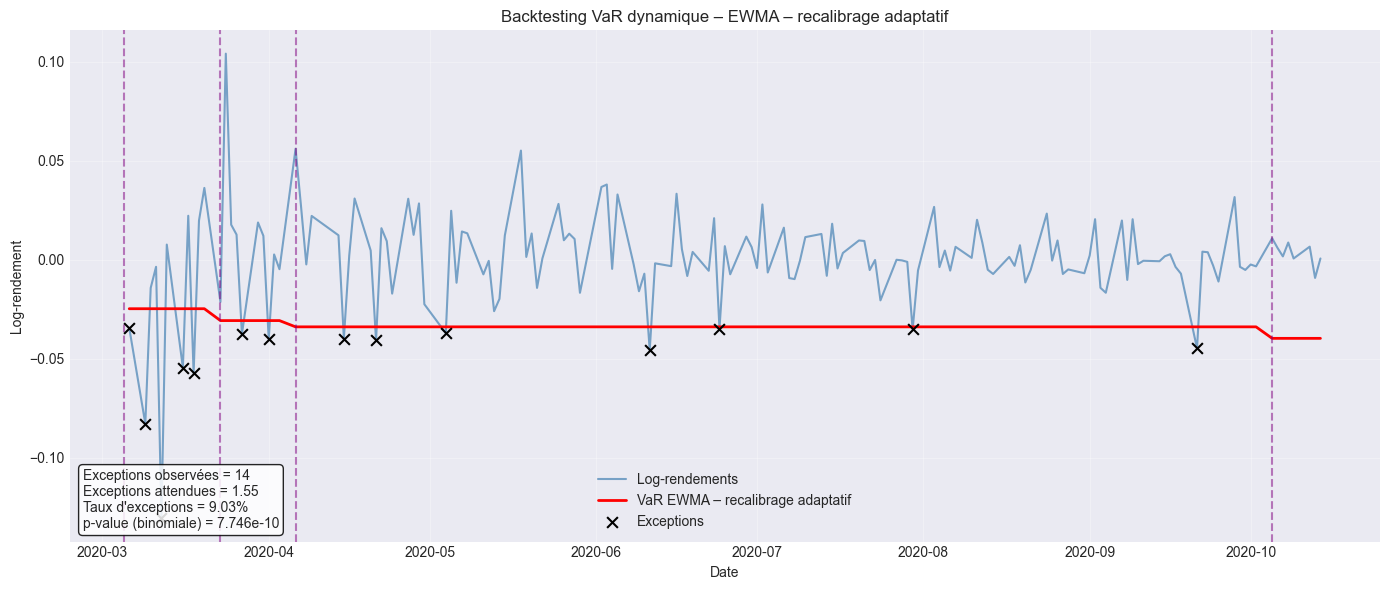

In [150]:
T = 250
n = len(train.returns)
backtest_results = backtest(train.returns, test.returns, 
                            initial_var= var_hist, persistence_days=10,
                            shift=1, alpha=0.99, test_name='christoffersen')
plot_exceptions_dynamic(
    returns_test=test.returns,
    alpha=0.99,
    var_dict=backtest_results,
    name='EWMA – recalibrage adaptatif'
)

# 5. VaR TVE : Approche Maxima par bloc

	Déterminer une taille de bloc s et construire un échantillon de maxima sur la base d’apprentissage.
	Tracer le Gumbel plot pour juger de l’hypothèse ξ=0 (i.e. GEV vs EV).
	Estimer les paramètres de loi GEV (ou EV si pertinent).
	Faire une validation ex-ante (analyses graphiques, QQ-plot, etc.).
	Calculer la VaR TVE par MB sur base d’apprentissage pour alpha = 99%.
	Proposer un protocole permettant de trouver une taille de bloc optimale (le qualificatif « optimal » étant subjectif, à vous d’en donner une définition), et le mettre en œuvre.


In [151]:
def block_maxima(returns, block_size=21):
    """
    Construction des maxima par blocs (TVE)
    returns : pd.Series de rendements
    block_size : taille du bloc (mois boursier ≈ 21 jours)
    """
    losses = -returns  # passage à la queue droite
    n_blocks = len(losses) // block_size
    
    maxima = [
        losses.iloc[i * block_size:(i + 1) * block_size].max()
        for i in range(n_blocks)
    ]
    
    return np.array(maxima)


Text(0.5, 1.0, 'Maxima par blocs (TVE) des rendements')

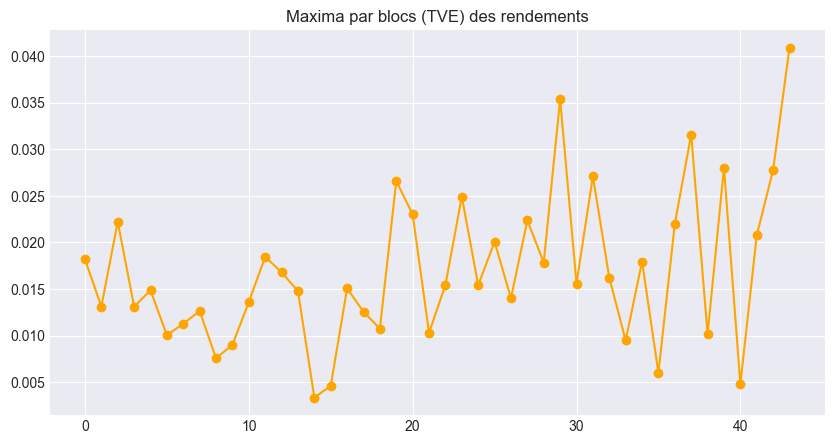

In [168]:
maxima = block_maxima(train.returns)
plt.figure(figsize=(10, 5))
plt.plot(maxima, marker='o', linestyle='-', color='orange')
plt.title("Maxima par blocs (TVE) des rendements")

In [153]:
def gumbel_plot(maxima):
    x = np.sort(maxima)
    n = len(x)
    p = (np.arange(1, n + 1) - 0.5) / n
    y = -np.log(-np.log(p))

    plt.figure(figsize=(6, 6))
    plt.scatter(x, y, alpha=0.7)
    plt.xlabel("Maxima empiriques")
    plt.ylabel(r"$-\log(-\log(F_n(x)))$")
    plt.title("Gumbel plot (test visuel ξ = 0)")
    plt.grid(alpha=0.3)
    plt.show()


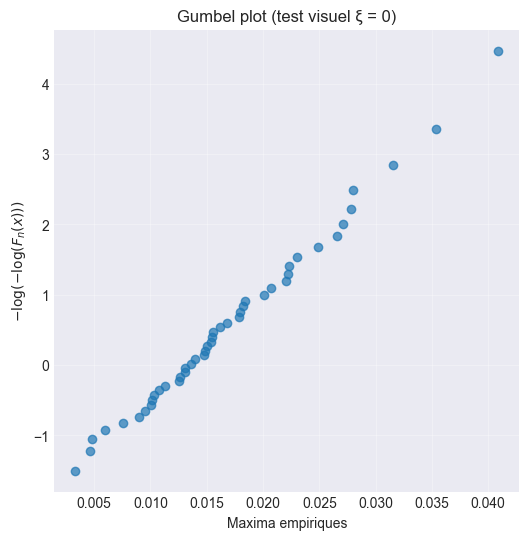

In [169]:
gumbel_plot(maxima)

In [155]:
from scipy.stats import genextreme

def fit_gev(maxima):
    """
    Estimation des paramètres GEV par MLE
    """
    xi, mu, sigma = genextreme.fit(maxima)
    return xi, mu, sigma


In [170]:
xi, mux, sigmax = fit_gev(maxima)
print(f"Paramètres GEV estimés : ξ = {xi:.4f}, μ = {mux:.4f}, σ = {sigmax:.4f}")    

Paramètres GEV estimés : ξ = -0.7600, μ = 0.0122, σ = 0.0090


In [387]:
def gev_plot(returns, block_size_min = 9, block_size_max = 50):
    """
    Visualisation des maxima par blocs et ajustement GEV
    """
    xis = []
    sizes = []
    for block_size in range(block_size_min, block_size_max + 1):
        maxima = block_maxima(returns, block_size=block_size)
        sizes.append(block_size)
        
        # Estimation des paramètres GEV
        xi, _, _ = fit_gev(maxima)
        xis.append(xi)
        
    plt.figure(figsize=(10, 5))
    plt.plot(range(block_size_min, block_size_max + 1), xis, marker='o')
    plt.axhline(0, color='red', linestyle='--', label='ξ = 0 (Gumbel)')
    plt.xlabel("Taille du bloc (jours)")        
    plt.ylabel("Paramètre ξ")
    plt.title("Évolution du paramètre ξ selon la taille du bloc")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    df = pd.DataFrame({'block_size': sizes, 'xi': xis})
    return df

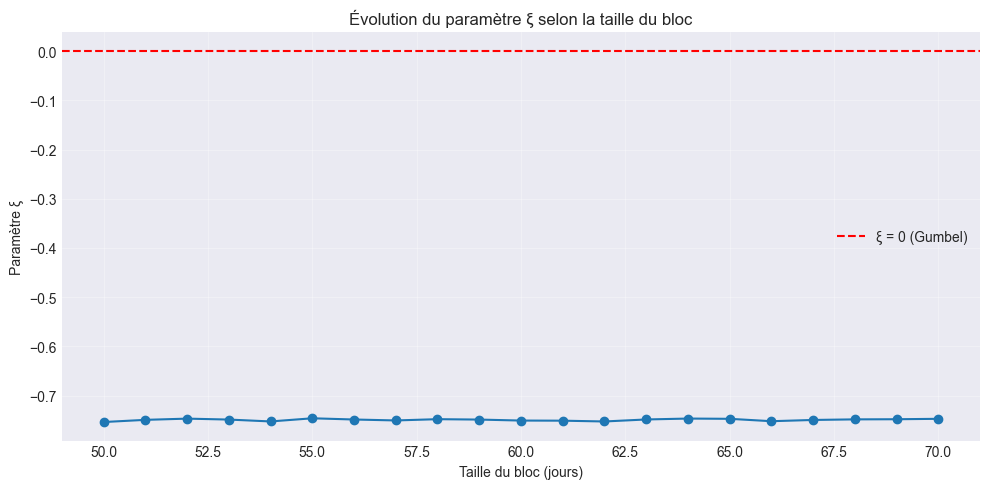

In [396]:
xis_df = gev_plot(train.returns, block_size_min = 50, block_size_max = 70)

In [389]:
xis_df

,block_size,xi
0,5,-0.074018
1,6,-0.737090
2,7,-0.073126
3,8,-0.006399
4,9,-0.762729
5,10,-0.766903
6,11,-0.023011
7,12,0.024854
8,13,-0.764223
9,14,0.079941


In [391]:
def qq_plot_gev(returns,size_block = 21):
    maxima = block_maxima(returns, block_size=size_block)
    xi, mu, sigma = fit_gev(maxima)
    n = len(maxima)
    probs = (np.arange(1, n + 1) - 0.5) / n
    
    q_emp = np.sort(maxima)
    q_theo = genextreme.ppf(probs, xi, loc=mu, scale=sigma)
    
    plt.figure(figsize=(6, 6))
    plt.scatter(q_theo, q_emp, alpha=0.7)
    plt.plot(q_theo, q_theo, 'r--')
    plt.xlabel("Quantiles théoriques GEV")
    plt.ylabel("Quantiles empiriques")
    plt.title("QQ-plot – Loi GEV")
    plt.grid(alpha=0.3)
    plt.show()


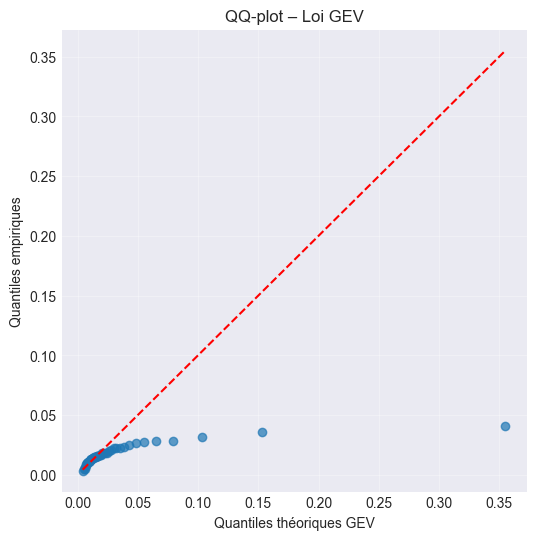

In [477]:
s=21
qq_plot_gev(train.returns, size_block=s)

In [ ]:
def var_tve_block_maxima(alpha, block_size, xi, mu, sigma):
    p = alpha ** block_size#1 - (1 - alpha) * block_size
    var_loss = genextreme.ppf(p, xi, loc=mu, scale=sigma)
    return -var_loss

VaR TVE (block maxima) à 99% : -5.2949%


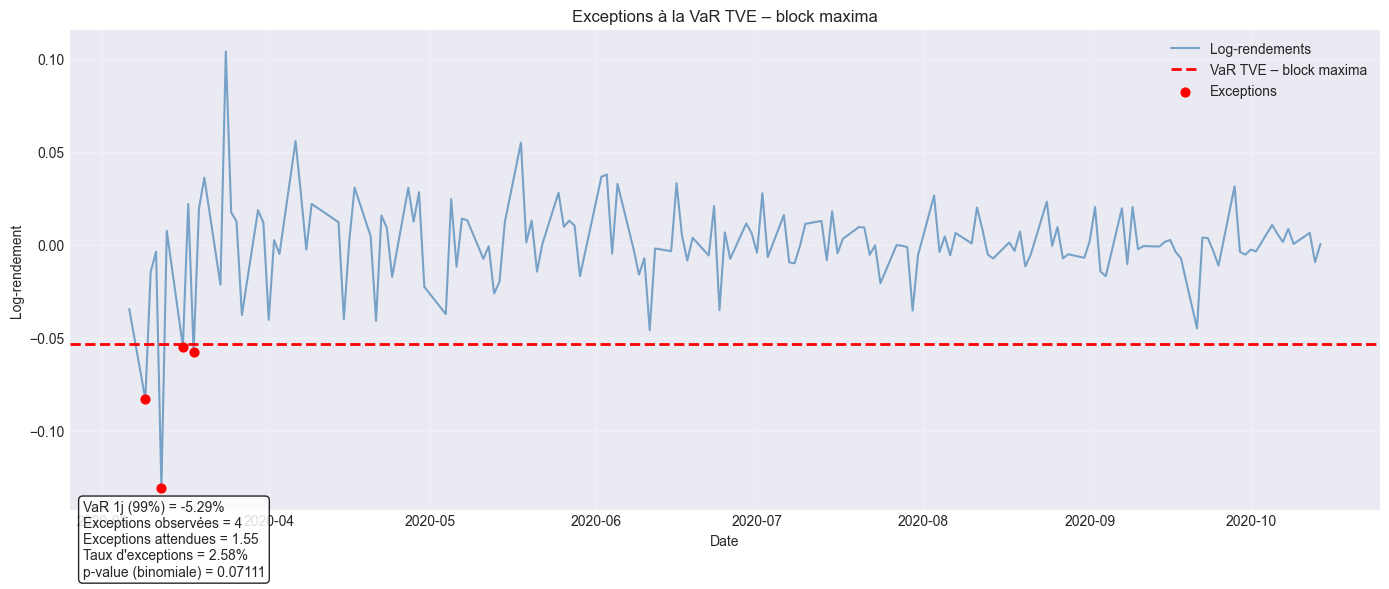

In [478]:
maxima = block_maxima(train.returns, block_size=s)
xi_bm, mu_bm, sigma_bm = fit_gev(maxima)
var_tve = var_tve_block_maxima(0.99, 14, xi_bm, mu_bm, sigma_bm)
print(f"VaR TVE (block maxima) à 99% : {var_tve:.4%}")
plot_exceptions(test.returns, alpha=0.99, var=var_tve, name='TVE – block maxima')       

## Gumbel

μ̂ = 0.0132, σ̂ = 0.0066
VaR TVE (Gumbel) à 99% : -2.3486%


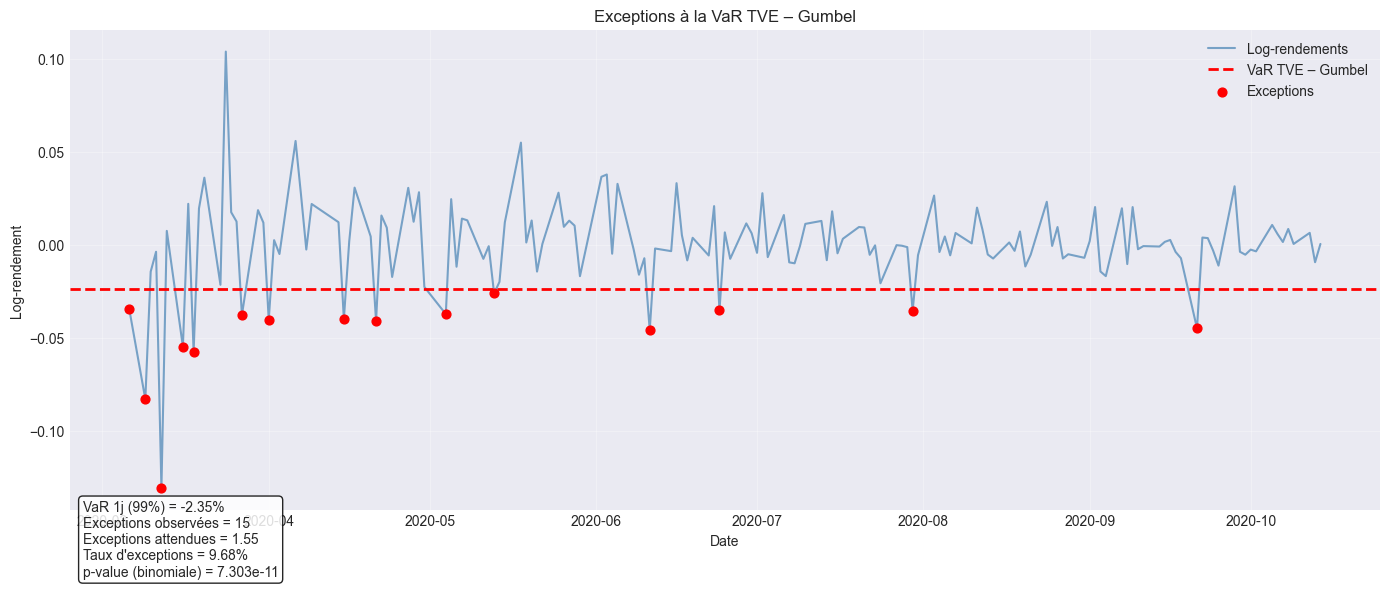

In [479]:
from scipy.stats import gumbel_r


loc_ev, scale_ev = gumbel_r.fit(maxima)
print(f"μ̂ = {loc_ev:.4f}, σ̂ = {scale_ev:.4f}")

p = alpha ** s#1 - (1 - alpha) * block_size
var_loss = gumbel_r.ppf(p, loc=loc_ev, scale=scale_ev)
print(f"VaR TVE (Gumbel) à 99% : {-var_loss:.4%}")
plot_exceptions(test.returns, alpha=0.99, var=-var_loss, name='TVE – Gumbel')

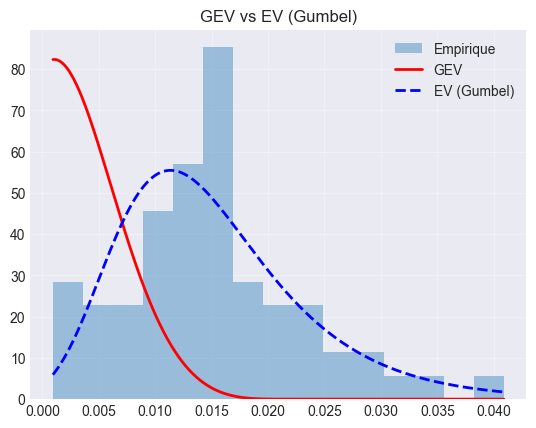

In [453]:
x = np.linspace(min(maxima), max(maxima), 500)

plt.hist(maxima, bins=15, density=True, alpha=0.4, label="Empirique")

plt.plot(x, genextreme.pdf(x, xi_hat, loc_hat, scale_hat),
         'r-', lw=2, label="GEV")

plt.plot(x, gumbel_r.pdf(x, loc_ev, scale_ev),
         'b--', lw=2, label="EV (Gumbel)")

plt.legend()
plt.grid(alpha=0.3)
plt.title("GEV vs EV (Gumbel)")
plt.show()


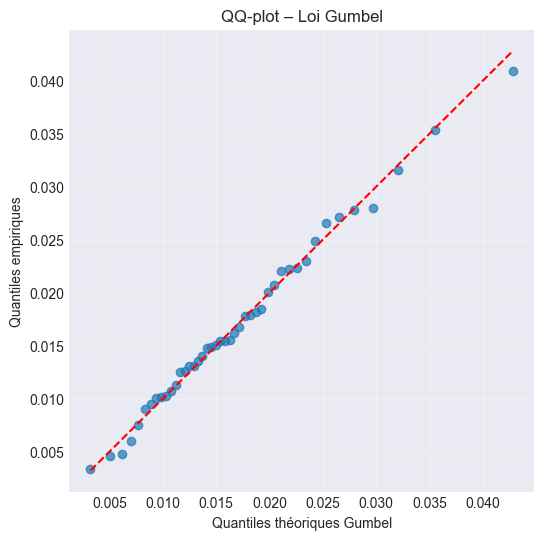

In [480]:
n = len(maxima)
probs = (np.arange(1, n + 1) - 0.5) / n

q_emp = np.sort(maxima)
q_theo = gumbel_r.ppf(probs, loc=loc_ev, scale=scale_ev)

plt.figure(figsize=(6, 6))
plt.scatter(q_theo, q_emp, alpha=0.7)
plt.plot(q_theo, q_theo, 'r--')
plt.xlabel("Quantiles théoriques Gumbel")
plt.ylabel("Quantiles empiriques")
plt.title("QQ-plot – Loi Gumbel")
plt.grid(alpha=0.3)
plt.show()


In [422]:
from pyextremes import EVA

eva = EVA(train.returns)
eva.get_extremes(method="BM", block_size="22D")

(<Figure size 768x480 with 1 Axes>, <Axes: xlabel='Date', ylabel='returns'>)

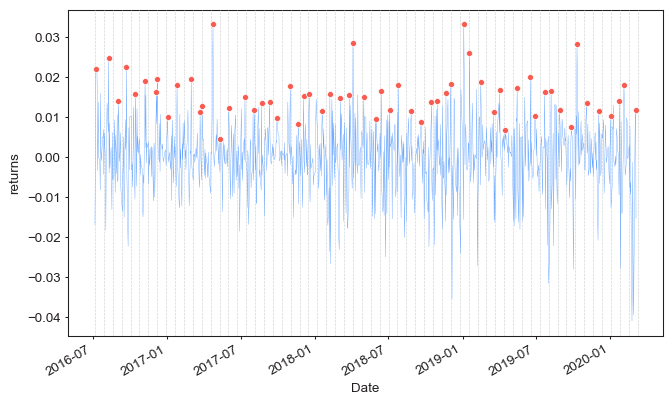

In [423]:
eva.plot_extremes()

(<Figure size 768x768 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='returns'>,
  <Axes: title={'center': 'Probability density plot'}, xlabel='returns', ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

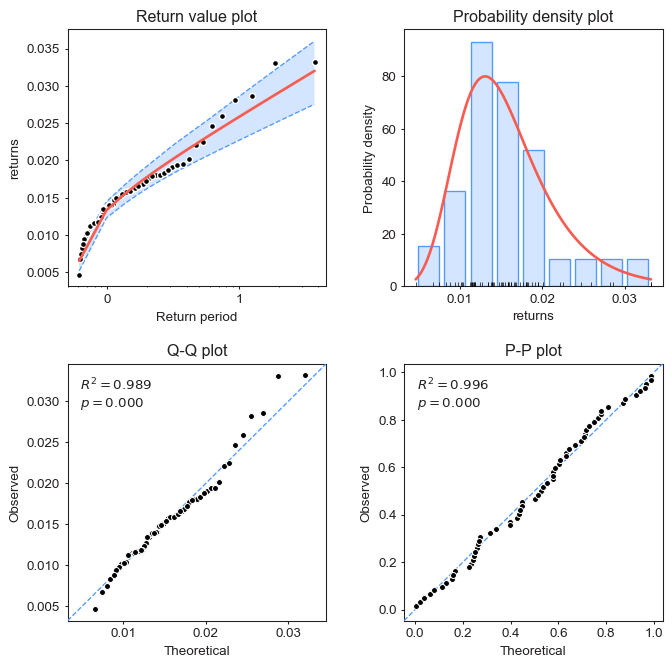

In [424]:
eva.fit_model()
eva.plot_diagnostic(alpha=0.95)

# 6.	VaR TVE : Approche Peak over threshold


## a.	Ecrire une fonction permettant d’obtenir le mean excess plot.

In [294]:
def mean_excess_plot(x, k_max=200):
    import matplotlib.pyplot as plt
    mean_excess = []
    x = x[x > 0]
    x_sorted = np.sort(x)[::-1]

    u_grid = x_sorted[5:k_max] 
    ks = np.arange(5, min(k_max, len(x_sorted)-1)) 
    for u in u_grid:
        exc = x[x > u] - u
        mean_excess.append(exc.mean())

    plt.figure(figsize=(8, 4))
    plt.plot(ks, mean_excess, marker='o')
    plt.xlabel("rang du seuil")
    plt.ylabel("Mean Excess")
    plt.title("Mean Excess Plot")
    plt.grid(alpha=0.3)
    plt.show()


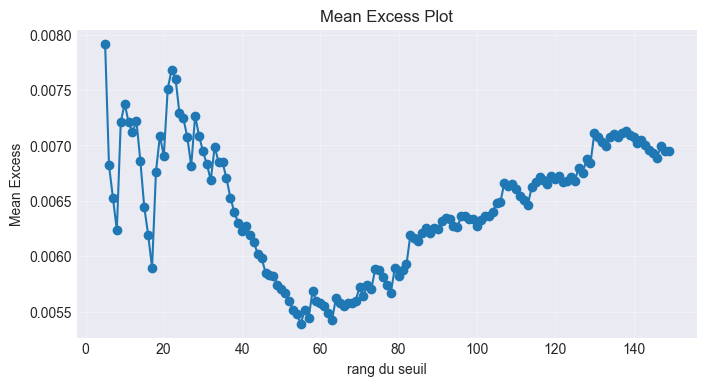

In [301]:
loss = -train.returns[ -train.returns > 0 ]
mean_excess_plot(loss, k_max=150)

## b.	Déterminer u par analyse graphique.
Attention : ne pas considérer ni les valeurs négatives de u, ni les valeurs trop extrêmes, au risque d’écraser l’échelle visuelle du graphique.

Une zone de stabilité, entre 90 et 110. Après la validation ex-anté u = **0.01016**

## c.	Estimer les paramètres de loi GPD.

### moments

In [209]:
def moments_estimator(x, k):
    """
    Estimateur de moments pour le paramètre de forme xi
    """
    x = np.asarray(x)
    x = x[x > 0]
    x_sorted = np.sort(x)[::-1]

    if k >= len(x_sorted):
        raise ValueError("k doit être strictement inférieur au nombre d'observations")

    threshold = x_sorted[k]
    excesses = np.log(x_sorted[:k] / threshold)

    mean_excess = np.mean(excesses)
    var_excess = np.mean(excesses**2)
    xi1 = mean_excess
    xi2 = 1 - 0.5 / (1- (mean_excess**2) / var_excess)
    xi_hat =  xi1 + xi2
    u = threshold
    sigma_hat = u * (1 - xi2) * xi1

    return xi_hat, xi1, xi2,u, sigma_hat

In [204]:
def moments_plot(losses, k_max=200):
    """
    Plot pour le choix de k pour l'estimateur de moments
    """
    ks = np.arange(5, min(k_max, len(losses)-1))
    xi_vals = [moments_estimator(losses, k) for k in ks]
    xi_vals0 = [val[0] for val in xi_vals]
    xi_vals1 = [val[1] for val in xi_vals]
    xi_vals2 = [val[2] for val in xi_vals]

    plt.figure(figsize=(10, 5))
    plt.plot(ks, xi_vals0, label="Estimateur de moments ξ̂")
    plt.plot(ks, xi_vals1, label="heavy-tail component")
    plt.plot(ks, xi_vals2, label="short-tail component")
    plt.xlabel("k (nombre d'extrêmes)")
    plt.ylabel("Estimateur de moments ξ̂")
    plt.title("Moments plot")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

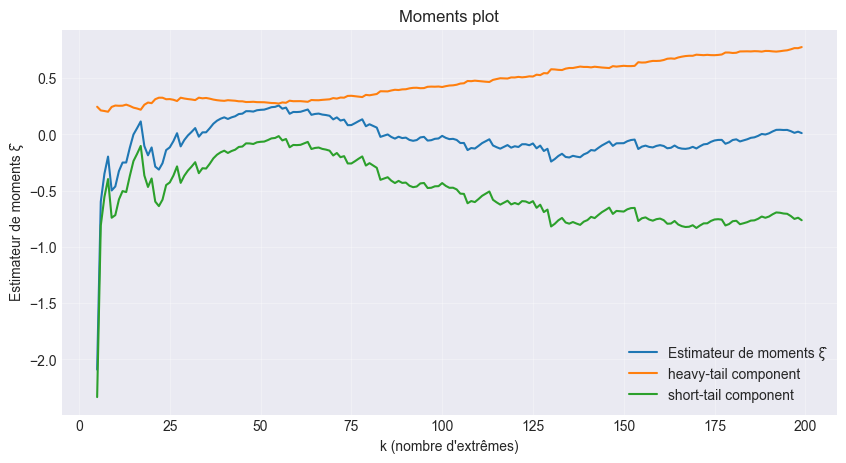

In [298]:
losses = -train.returns
moments_plot(losses, k_max=200)

### estimateur de hill

In [ ]:
def hill_estimator(x, k):
    """
    Estimateur de Hill du paramètre de forme xi (>0)
    
    Paramètres
    ----------
    x : array-like
        Observations (doivent être positives)
    k : int
        Nombre d'observations extrêmes utilisées

    Retour
    ------
    xi_hat : float
    """
    x = np.asarray(x)
    x = x[x > 0]
    x_sorted = np.sort(x)[::-1]  # décroissant

    if k >= len(x_sorted):
        raise ValueError("k doit être strictement inférieur au nombre d'observations")

    threshold = x_sorted[k]
    xi_hat = np.mean(np.log(x_sorted[:k] / threshold))

    return xi_hat


In [ ]:
def hill_plot(x, k_max=200):
    """
    Hill plot pour le choix de k
    """
    x = np.asarray(x)
    x = x[x > 0]
    x_sorted = np.sort(x)[::-1]

    ks = np.arange(5, min(k_max, len(x_sorted)-1))
    xi_vals = [hill_estimator(x_sorted, k) for k in ks]

    plt.figure(figsize=(10, 5))
    plt.plot(ks, xi_vals)
    plt.xlabel("k (nombre d'extrêmes)")
    plt.ylabel("Estimateur de Hill ξ̂")
    plt.title("Hill plot")
    plt.grid(alpha=0.3)
    plt.show()


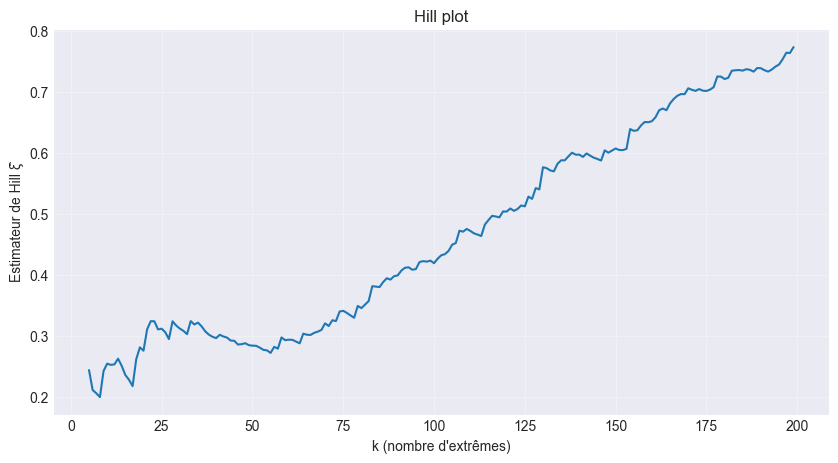

In [ ]:
losses = -train.returns
hill_plot(losses,)

### GPD

In [227]:
def genpareto_mle_estimator(x, k):
    """
    Estimateur de moments pour la loi de Pareto généralisée
    """
    x = np.asarray(x)
    x = x[x > 0]
    x_sorted = np.sort(x)[::-1]

    if k >= len(x_sorted):
        raise ValueError("k doit être strictement inférieur au nombre d'observations")

    threshold = x_sorted[k]
    excesses = x_sorted[:k] - threshold
    xi_hat, loc_hat, scale_hat = genpareto.fit(excesses, floc=0)
    return xi_hat, loc_hat, scale_hat, threshold

In [364]:
def genpareto_mm_estimator(x, k):
    """
    Estimateur de moments pour la loi de Pareto généralisée
    """
    x = np.asarray(x)
    x = x[x > 0]
    x_sorted = np.sort(x)[::-1]

    if k >= len(x_sorted):
        raise ValueError("k doit être strictement inférieur au nombre d'observations")

    threshold = x_sorted[k]
    excesses = x_sorted[:k] - threshold
    mean_excess = np.mean(excesses)
    var_excess = np.var(excesses)

    xi_hat = 0.5 * (1- mean_excess**2 / var_excess )
    scale_hat = 0.5 * mean_excess * (1+ mean_excess**2 / var_excess)

    return xi_hat, scale_hat, threshold

In [365]:
def gpd_plot(losses, k_max=200):
    """
    Plot pour le choix de k pour l'estimateur de moments et MLE de la loi de Pareto généralisée
     - losses : série des pertes (valeurs positives)
    """
    ks = np.arange(5, min(k_max, len(losses)-1))
    xi_valsMM = [moments_estimator(losses, k)[0] for k in ks]
    xi_valsMLE = [genpareto_mle_estimator(losses, k)[0] for k in ks]
    xi_valsMMGPD = [genpareto_mm_estimator(losses, k)[0] for k in ks]


    plt.figure(figsize=(10, 5))
    plt.plot(ks, xi_valsMM, label="Estimateur de moments ξ̂")
    plt.plot(ks, xi_valsMLE, label="Estimateur MLE ξ̂")
    plt.plot(ks, xi_valsMMGPD, label="Estimateur de moments GPD ξ̂")
    plt.xlabel("k (nombre d'extrêmes)")
    plt.ylabel("Estimateur de ξ̂")
    plt.title("Recherche du seuil optimal pour la loi de Pareto généralisée")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()
    return xi_valsMM, xi_valsMLE, xi_valsMMGPD

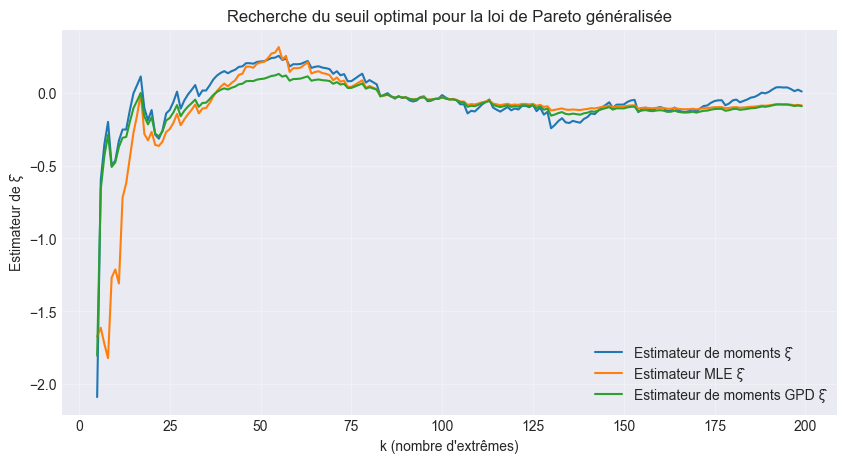

In [366]:
losses = -train.returns[-train.returns > 0]
losses = np.sort(losses)[::-1]
xi_valsMM, xi_valsMLE, xi_valsMMGPD = gpd_plot(losses, k_max=200)

In [367]:
xi_df = pd.DataFrame({
    "k": np.arange(5, min(200, len(losses)-1)),
    "xi_MM": xi_valsMM,
    "xi_MLE": xi_valsMLE,
    "xi_MM_GPD": xi_valsMMGPD
})
xi_df.iloc[75:100]

,k,xi_MM,xi_MLE,xi_MM_GPD
75,80,0.088317,0.047862,0.039207
76,81,0.073058,0.036184,0.030550
77,82,0.058517,0.025678,0.022319
78,83,-0.023674,-0.022599,-0.022193
79,84,-0.012661,-0.017587,-0.017101
80,85,-0.002120,-0.012715,-0.012149
81,86,-0.024604,-0.024819,-0.024487
82,87,-0.039179,-0.032453,-0.032701
83,88,-0.022295,-0.025004,-0.024734
84,89,-0.034465,-0.031459,-0.031661


## d.	Faire une validation ex-ante (analyse graphiques, QQ-plot, etc.).

In [244]:
def qqplot_gpd_mle(xi, loc, scale,excesses,name='GPD MLE'):
    n = len(excesses)
    excesses_sorted = np.sort(excesses)
    p = (np.arange(1, n+1) - 0.5) / n

    q_theo = genpareto.ppf(p, c=xi, scale=scale, loc=loc)
    plt.figure(figsize=(6, 6))
    plt.scatter(q_theo, excesses_sorted)
    plt.plot([0, max(q_theo)], [0, max(q_theo)], 'r--')
    plt.xlabel("Quantiles théoriques GPD")
    plt.ylabel("Quantiles empiriques")
    plt.title(f"QQ-plot – {name}")
    plt.grid(alpha=0.3)
    plt.show()


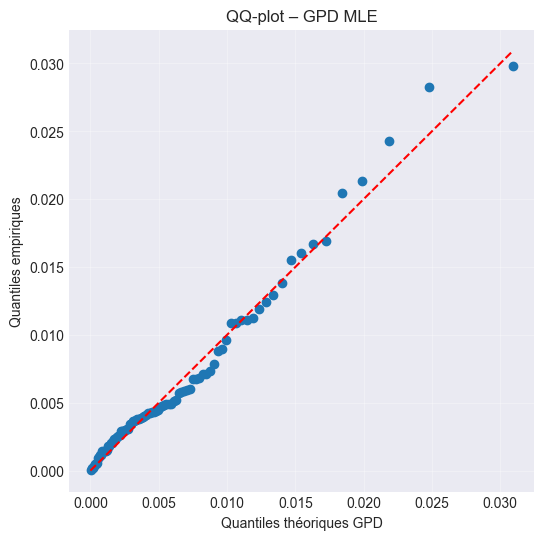

In [368]:
k=90 #83 MM,92,95,97,98,100,101,104 MLE
excesses = losses[losses > losses[k]] - losses[k]
#xi_mle, loc_mle, scale_mle,_ = genpareto_mle_estimator(losses, k)
xi_mle, loc_mle, scale_mle,_ = genpareto_mle_estimator(losses, k)
#xi_mm, _,_,loc_mm, scale_mm = moments_estimator(losses, k)
# print(f"xî = {xi_mle:.4f}")
# print(f"u = {loc_mle:.4f}")
# print(f"sig  = {scale_mle:.4f}")
# print(f"xî = {xi_mm:.4f}")
# print(f"u = {loc_mm:.4f}")
# print(f"sig  = {scale_mm:.4f}")
qqplot_gpd_mle(xi_mle, loc_mle, scale_mle,excesses,name='GPD MLE')
#qqplot_gpd_mle(xi_mm, loc_mm, scale_mm,excesses,name='GPD Moments')

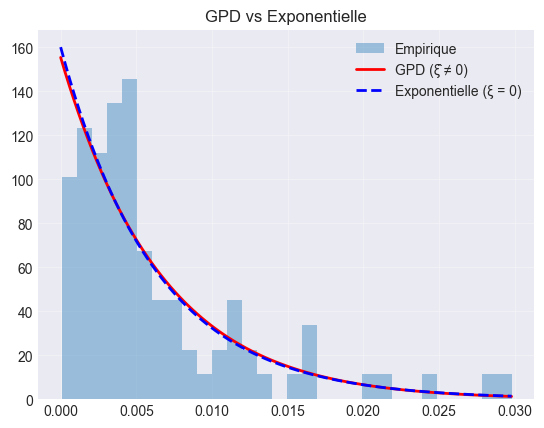

In [377]:
from scipy.stats import expon
x = np.linspace(0, excesses.max(), 100)
plt.hist(excesses, bins=30, density=True, alpha=0.4, label="Empirique")

plt.plot(x, genpareto.pdf(x, c=xi_mle, loc=loc_mle, scale=scale_mle),
         'r-', lw=2, label="GPD (ξ̂ ≠ 0)")

plt.plot(x, expon.pdf(x, scale=np.mean(excesses)),
         'b--', lw=2, label="Exponentielle (ξ = 0)")

plt.legend()
plt.grid(alpha=0.3)
plt.title("GPD vs Exponentielle")
plt.show()



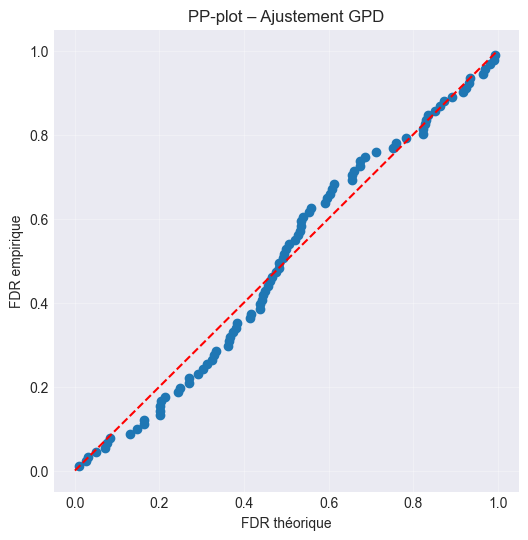

In [378]:
excesses_sorted = np.sort(excesses)
n = len(excesses_sorted)

p_emp = np.arange(1, n+1) / (n+1)
p_theo = genpareto.cdf(excesses_sorted, c=xi_mle, loc=loc_mle, scale=scale_mle)

plt.figure(figsize=(6, 6))
plt.scatter(p_theo, p_emp)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("FDR théorique")
plt.ylabel("FDR empirique")
plt.title("PP-plot – Ajustement GPD")
plt.grid(alpha=0.3)
plt.show()

## e.	Calculer la VaR TVE par PoT sur base d’apprentissage pour alpha = 99%

VaR TVE (GPD MLE) à 99% : -2.5243%


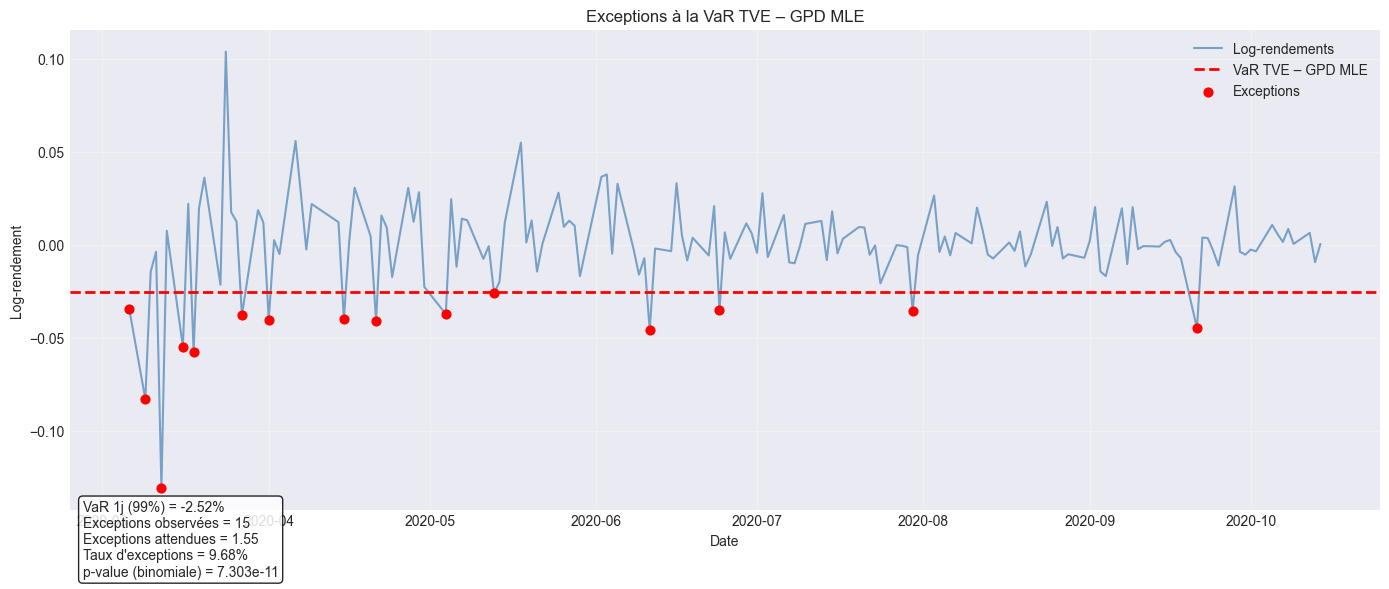

In [375]:
alpha = 0.99
n_ex = k#len(excesses)
n = len(train.returns)
p_gpd = (1 - alpha) * (n / n_ex)
var_tve_gpd = losses[k] + loc_mle + scale_mle * ((p_gpd)**(-xi_mle) - 1) / xi_mle
var_tve_gpd = -var_tve_gpd

print(f"VaR TVE (GPD MLE) à {alpha*100:.0f}% : {var_tve_gpd:.4%}")
plot_exceptions(test.returns, alpha=alpha, var=var_tve_gpd, name='TVE – GPD MLE')    

In [371]:
losses[k]

np.float64(0.011092861419612)

In [372]:
var_hist

np.float64(-0.02467965931831932)